# Experiment 3 & 4

- Rank metrics for each model for store & upc. The metrics are the average over all folds. (total of 52 weeks)
- Plots over time
- Statistical tests to compare predictions from experiment 3 with experiment 4 


In [2]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import yaml
from tqdm import tqdm 
from glob import glob

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))


from metrics import *
from utils import *

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['breakfast']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)
    

In [3]:
stores = list(params['breakfast']['dataset']['store_ids'].keys())
upcs = list(params['breakfast']['dataset']['upc_ids'].keys())

full_search = list(itertools.product(stores, upcs))

date_ranges = make_dates(params['breakfast']['experiment_dates'])['test_end']

In [4]:
# Select a paid of store and upc:
# Currently only has 3 to 7.
store, upc = full_search[0]

In [5]:
# Aggregate all predictions of each model for exp3

all_stores_upc = {}
base_mae_rmse_ll = []

for store, upc in full_search:
    xgb_exp3 =[]
    xgb_exp4 =[]
    lstm_exp3 =[]
    lstm_exp4 =[]
    
    for fpath in glob(str(proj_path / f'data/04_results/*')):
        if ('olist' in fpath) | ('breakfast' in fpath):
            pass
        else:
            xgb_exp3.append(pd.read_csv(os.path.join(fpath,f'xgb_exp3_{store}_{upc}.csv')))
            xgb_exp4.append(pd.read_csv(os.path.join(fpath,f'xgb_exp4_{store}_{upc}.csv')))
            lstm_exp3.append(pd.read_csv(os.path.join(fpath,f'lstm_exp3_{store}_{upc}.csv')))
            lstm_exp4.append(pd.read_csv(os.path.join(fpath,f'lstm_exp4_{store}_{upc}.csv')))

    xgb_exp3 = pd.concat(xgb_exp3).reset_index(drop=True)
    xgb_exp4 = pd.concat(xgb_exp4).reset_index(drop=True)
    lstm_exp3 = pd.concat(lstm_exp3).reset_index(drop=True)
    lstm_exp4 = pd.concat(lstm_exp4).reset_index(drop=True)
    
    # clean up each experiments and standardize their outputs here
    xgb_exp3 = xgb_exp3.rename(columns={'test_predictions':'y_pred_xgb',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb','y_true']]
    xgb_exp4 = xgb_exp4.rename(columns={'test_predictions':'y_pred_xgb_gtrend',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb_gtrend','y_true']]
    lstm_exp3['dates'] = xgb_exp3['dates']
    lstm_exp3.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp3 = lstm_exp3.rename(columns={'y_pred':'y_pred_lstm'})
    lstm_exp4['dates'] = xgb_exp3['dates']
    lstm_exp4.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp4 = lstm_exp4.rename(columns={'y_pred':'y_pred_lstm_gtrend'})
    
    xgb_exp3.set_index('dates', inplace=True)
    xgb_exp4.set_index('dates', inplace=True)
    lstm_exp3.set_index('dates', inplace=True)
    lstm_exp4.set_index('dates', inplace=True)

    base_metrics = pd.read_csv(proj_path / catalog['results']['dir'] / 'breakfast' / f'naive_training_{store}_{upc}.csv')

    df = pd.concat([xgb_exp3[['y_true','y_pred_xgb']],
                    xgb_exp4['y_pred_xgb_gtrend'],
                    lstm_exp3['y_pred_lstm'],
                    lstm_exp4['y_pred_lstm_gtrend']],axis=1)
    all_stores_upc[f'{store}_{upc}'] = df
    
    base_mae_rmse_ll.append({'store': store,
                             'upc':upc,
                             'base_mae':base_metrics['train_mae'].values[0],
                             'base_rmse':base_metrics['train_rmse'].values[0]})
    
base_mae_rmse = pd.DataFrame(base_mae_rmse_ll)

In [6]:
def get_min_max(df, date_ranges):
    
    _metrics_xgb = []
    _metrics_xgb_gtrends = []
    _metrics_lstm = []
    _metrics_lstm_gtrends = []
    
    for window in date_ranges.itertuples():
        # Filter period
        temp = df[(pd.to_datetime(df.index) >= window[5]) & 
                  (pd.to_datetime(df.index) <= window[6])]
        _metrics_xgb.append(get_metrics(temp['y_true'],temp['y_pred_xgb']))
        _metrics_xgb_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_xgb_gtrend']))
        _metrics_lstm.append(get_metrics(temp['y_true'],temp['y_pred_lstm']))
        _metrics_lstm_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend']))
    
    # Get the min and max for each metric for each model
    return pd.DataFrame({'model':['xgb','xgb_gtrend','lstm','lstm_gtrend'],
                      'min_wape':[pd.DataFrame(_metrics_xgb)['wape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].min()],
                      'min_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].min()],
                      'min_r2':[pd.DataFrame(_metrics_xgb)['r2'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].min()],
                     'min_mape':[pd.DataFrame(_metrics_xgb)['mape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].min()],
                     'max_wape':[pd.DataFrame(_metrics_xgb)['wape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].max()],
                      'max_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].max()],
                      'max_r2':[pd.DataFrame(_metrics_xgb)['r2'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].max()],
                     'max_mape':[pd.DataFrame(_metrics_xgb)['mape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].max()],
                     'max_mae':[pd.DataFrame(_metrics_xgb)['mae'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mae'].max(),
                                 pd.DataFrame(_metrics_lstm)['mae'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mae'].max()],
                     'min_mae':[pd.DataFrame(_metrics_xgb)['mae'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mae'].min(),
                                 pd.DataFrame(_metrics_lstm)['mae'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mae'].min()]})
    

In [13]:
metrics_df = pd.DataFrame()
metrics_mase_rmsse = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for store, upc in full_search:

        temp = all_stores_upc[f'{store}_{upc}']

        # Get metrics for each model
        metrics_xgb = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_xgb_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])
        metrics_lstm = get_metrics(temp['y_true'],temp['y_pred_lstm'])
        metrics_lstm_gtrends = get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend'])

        results = pd.DataFrame([metrics_xgb,
                                metrics_xgb_gtrends,
                                metrics_lstm,
                                metrics_lstm_gtrends], 
                           index=['xgb','xgb_gtrend','lstm','lstm_gtrend'])
        
        results['store'] = store
        results['upc'] = upc
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0, ascending=False)['r2']
        
        # Add rank for rmsse and mase
        results = results.merge(base_mae_rmse, how='left', on=['store','upc'])
        results['mase'] = results['mae'] / results['base_mae']
        results['rmsse'] = results['rmse'] / results['base_rmse']
        results['rank_rmsse'] = results.rank(axis=0)['rmsse']
        results['rank_mase'] = results.rank(axis=0)['mase']
        
        min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
        results = results.merge(min_max_df, how='inner',on='model')  

        # Calculate the minimum and maximum of each fold.
        #metrics_df = metrics_df.append(results).reset_index(drop=True)
        metrics_df = pd.concat([metrics_df, results], ignore_index=True)

In [14]:
metrics_df[['model', 'store', 'upc', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

model  store         upc      mase     rmsse  rank_mase  rank_rmsse
0           xgb   2277  1600027527  1.130674  0.853968        4.0         3.0
1    xgb_gtrend   2277  1600027527  1.076502  0.942220        3.0         4.0
2          lstm   2277  1600027527  0.861527  0.812259        1.0         1.0
3   lstm_gtrend   2277  1600027527  0.924560  0.821101        2.0         2.0
4           xgb   2277  3800031838  1.034834  0.851788        4.0         4.0
..          ...    ...         ...       ...       ...        ...         ...
91  lstm_gtrend  25229  1111009477  0.994894  0.890555        3.5         3.5
92          xgb  25229  7192100339  0.852097  0.727897        1.5         1.5
93   xgb_gtrend  25229  7192100339  0.962253  0.795727        3.5         3.5
94         lstm  25229  7192100339  0.852097  0.727897        1.5         1.5
95  lstm_gtrend  25229  7192100339  0.962253  0.795727        3.5         3.5

[96 rows x 7 columns]

In [15]:
metrics_df

model          wape        rmse        r2      mape        mae  \
0           xgb  12215.789412  102.982168 -0.231999  0.298653  65.826923   
1    xgb_gtrend  10811.784072  113.624635 -0.499793  0.301003  62.673077   
2          lstm  12012.669579   97.952324 -0.114592  0.197837  50.157378   
3   lstm_gtrend  11950.718006   99.018672 -0.138992  0.235992  53.827118   
4           xgb   4212.795837   63.865694 -0.447418  0.387303  39.826923   
..          ...           ...         ...       ...       ...        ...   
91  lstm_gtrend    429.788347   16.639875 -0.152851  0.289006  13.942149   
92          xgb    353.059932   14.525880 -0.076108  0.300793  11.374907   
93   xgb_gtrend    349.295211   15.879491 -0.286010  0.376636  12.845424   
94         lstm    353.059932   14.525880 -0.076108  0.300793  11.374907   
95  lstm_gtrend    349.295211   15.879491 -0.286010  0.376636  12.845424   

    store         upc  rank_mape  rank_wape  ...    min_wape   min_rmse  \
0    2277  1600027527        3.0        4.0  ...  146.950000   5.958188   
1    2277  1600027527        4.0        1.0  ...  169.135714  11.467345   
2    2277  1600027527        1.0        3.0  ...  108.386655   5.709083   
3    2277  1600027527        2.0        2.0  ...  169.872306   5.565220   
4    2277  3800031838        4.0        4.0  ...  146.950000   5.958188   
..    ...         ...        ...        ...  ...         ...        ...   
91  25229  1111009477        3.5        3.5  ...  169.872306   5.565220   
92  25229  7192100339        1.5        3.5  ...  146.950000   5.958188   
93  25229  7192100339        3.5        1.5  ...  169.135714  11.467345   
94  25229  7192100339        1.5        3.5  ...  108.386655   5.709083   
95  25229  7192100339        3.5        1.5  ...  169.872306   5.565220   

       min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  \
0  -35.969697  0.139971  1434.300000  31.815877 -0.203390  0.610809   
1  -16.780488  0.206395  1396.684375  32.546121 -0.497221  1.070164   
2  -12.837301  0.123403  1012.913275  23.625861  0.144045  0.529507   
3  -26.988496  0.105332   988.973890  22.945169  0.151324  0.818980   
4  -35.969697  0.139971  1434.300000  31.815877 -0.203390  0.610809   
..        ...       ...          ...        ...       ...       ...   
91 -26.988496  0.105332   988.973890  22.945169  0.151324  0.818980   
92 -35.969697  0.139971  1434.300000  31.815877 -0.203390  0.610809   
93 -16.780488  0.206395  1396.684375  32.546121 -0.497221  1.070164   
94 -12.837301  0.123403  1012.913275  23.625861  0.144045  0.529507   
95 -26.988496  0.105332   988.973890  22.945169  0.151324  0.818980   

      max_mae   min_mae  
0   27.750000  5.000000  
1   27.750000  9.250000  
2   20.015842  4.807538  
3   21.094258  4.774178  
4   27.750000  5.000000  
..        ...       ...  
91  21.094258  4.774178  
92  27.750000  5.000000  
93  27.750000  9.250000  
94  20.015842  4.807538  
95  21.094258  4.774178  

[96 rows x 28 columns]

In [17]:
metrics_df_xgb = pd.DataFrame()
metrics_df_lstm = pd.DataFrame()
metrics_df_xgb_mase_rmsse = pd.DataFrame()
metrics_df_lstm_mase_rmsse = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for store, upc in full_search:

        temp = all_stores_upc[f'{store}_{upc}']

        # Get metrics for each model
        metrics = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])

        results = pd.DataFrame([metrics,
                                metrics_gtrends], 
                                index=[model,f'{model}_gtrend'])
        results['store'] = store
        results['upc'] = upc
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0, ascending=False)['r2']
        
        # Add rank for rmsse and mase
        results = results.merge(base_mae_rmse, how='left', on=['store', 'upc'])
        results['mase'] = results['mae'] / results['base_mae']
        results['rmsse'] = results['rmse'] / results['base_rmse']
        results['rank_rmsse'] = results.rank(axis=0)['rmsse']
        results['rank_mase'] = results.rank(axis=0)['mase']
        
        
        min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
        # left to only include model specific
        results = results.merge(min_max_df, how='left',on='model')  

        # Calculate the minimum and maximum of each fold.
        if model == 'xgb':
            #metrics_df_xgb = metrics_df_xgb.append(results).reset_index(drop=True)
            #metrics_df_xgb_mase_rmsse = metrics_df_xgb_mase_rmsse.append(results).reset_index(drop=True)
            metrics_df_xgb = pd.concat([metrics_df_xgb, results], ignore_index=True)
            metrics_df_xgb_mase_rmsse = pd.concat([metrics_df_xgb_mase_rmsse, results], ignore_index=True)

        if model =='lstm':
            #metrics_df_lstm = metrics_df_lstm.append(results).reset_index(drop=True)
            #metrics_df_lstm_mase_rmsse = metrics_df_lstm_mase_rmsse.append(results).reset_index(drop=True)
            metrics_df_lstm = pd.concat([metrics_df_lstm, results], ignore_index=True)
            metrics_df_lstm_mase_rmsse = pd.concat([metrics_df_lstm_mase_rmsse, results], ignore_index=True)


In [18]:
metrics_df_xgb_mase_rmsse[['model', 'store', 'upc', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

model  store         upc      mase     rmsse  rank_mase  rank_rmsse
0          xgb   2277  1600027527  1.130674  0.853968        2.0         1.0
1   xgb_gtrend   2277  1600027527  1.076502  0.942220        1.0         2.0
2          xgb   2277  3800031838  1.034834  0.851788        2.0         2.0
3   xgb_gtrend   2277  3800031838  0.917909  0.787708        1.0         1.0
4          xgb   2277  1111009477  1.733889  1.658624        2.0         2.0
5   xgb_gtrend   2277  1111009477  1.397870  1.303017        1.0         1.0
6          xgb   2277  7192100339  1.395163  1.237508        1.0         1.0
7   xgb_gtrend   2277  7192100339  1.406017  1.255410        2.0         2.0
8          xgb    389  1600027527  0.788326  0.658713        1.0         1.0
9   xgb_gtrend    389  1600027527  0.864964  0.686869        2.0         2.0
10         xgb    389  3800031838  1.080042  1.069068        1.0         1.0
11  xgb_gtrend    389  3800031838  1.284823  1.190228        2.0         2.0
12         xgb    389  1111009477  1.303532  1.292593        2.0         2.0
13  xgb_gtrend    389  1111009477  1.237753  1.213772        1.0         1.0
14         xgb    389  7192100339  1.215314  1.154962        1.0         1.0
15  xgb_gtrend    389  7192100339  1.444917  1.226742        2.0         2.0
16         xgb  25229  1600027527  1.183356  1.090178        1.0         1.0
17  xgb_gtrend  25229  1600027527  1.332762  1.092791        2.0         2.0
18         xgb  25229  3800031838  1.126543  0.878874        2.0         2.0
19  xgb_gtrend  25229  3800031838  0.869139  0.747635        1.0         1.0
20         xgb  25229  1111009477  1.369539  1.209730        2.0         2.0
21  xgb_gtrend  25229  1111009477  1.060775  1.141775        1.0         1.0
22         xgb  25229  7192100339  1.215850  1.041154        2.0         1.0
23  xgb_gtrend  25229  7192100339  1.188479  1.042382        1.0         2.0

In [19]:
metrics_df_xgb

model          wape        rmse        r2      mape        mae  \
0          xgb  12215.789412  102.982168 -0.231999  0.298653  65.826923   
1   xgb_gtrend  10811.784072  113.624635 -0.499793  0.301003  62.673077   
2          xgb   4212.795837   63.865694 -0.447418  0.387303  39.826923   
3   xgb_gtrend   3879.458092   59.061083 -0.237832  0.326010  35.326923   
4          xgb   7665.640777   66.140730 -1.447318  0.282308  50.211538   
5   xgb_gtrend   6595.077919   51.960229 -0.510409  0.207319  40.480769   
6          xgb   2256.236002   51.319137 -0.988972  0.691072  37.076923   
7   xgb_gtrend   2124.825746   52.061539 -1.046934  0.688822  37.365385   
8          xgb   6117.432484   78.514942 -0.331319  0.380455  40.750000   
9   xgb_gtrend   6235.344784   81.871029 -0.447565  0.428565  44.711538   
10         xgb   5002.798372   77.002997 -0.353528  0.484059  39.961538   
11  xgb_gtrend   4729.120694   85.729898 -0.677708  0.697864  47.538462   
12         xgb   1598.077602   30.174174 -1.346593  0.233914  22.865385   
13  xgb_gtrend   1866.741063   28.334201 -1.069136  0.198118  21.711538   
14         xgb   1151.300969   36.018692 -0.492578  0.575566  23.615385   
15  xgb_gtrend   1084.106316   38.257227 -0.683868  0.878697  28.076923   
16         xgb   6075.751935   94.045100 -0.660263  0.425395  44.019231   
17  xgb_gtrend   6134.195049   94.270478 -0.668231  0.464414  49.576923   
18         xgb   2254.101196   54.179367 -0.900913  0.392958  33.750000   
19  xgb_gtrend   2226.147868   46.088961 -0.375588  0.279132  26.038462   
20         xgb    593.596513   22.603608 -1.127299  0.392308  19.192308   
21  xgb_gtrend    550.981668   21.333884 -0.895016  0.290919  14.865385   
22         xgb    491.606971   20.777206 -1.201635  0.407256  16.230769   
23  xgb_gtrend    469.525000   20.801720 -1.206833  0.434290  15.865385   

    store         upc  rank_mape  rank_wape  ...    min_wape   min_rmse  \
0    2277  1600027527        1.0        2.0  ...  146.950000   5.958188   
1    2277  1600027527        2.0        1.0  ...  169.135714  11.467345   
2    2277  3800031838        2.0        2.0  ...  146.950000   5.958188   
3    2277  3800031838        1.0        1.0  ...  169.135714  11.467345   
4    2277  1111009477        2.0        2.0  ...  146.950000   5.958188   
5    2277  1111009477        1.0        1.0  ...  169.135714  11.467345   
6    2277  7192100339        2.0        2.0  ...  146.950000   5.958188   
7    2277  7192100339        1.0        1.0  ...  169.135714  11.467345   
8     389  1600027527        1.0        1.0  ...  146.950000   5.958188   
9     389  1600027527        2.0        2.0  ...  169.135714  11.467345   
10    389  3800031838        1.0        2.0  ...  146.950000   5.958188   
11    389  3800031838        2.0        1.0  ...  169.135714  11.467345   
12    389  1111009477        2.0        1.0  ...  146.950000   5.958188   
13    389  1111009477        1.0        2.0  ...  169.135714  11.467345   
14    389  7192100339        1.0        2.0  ...  146.950000   5.958188   
15    389  7192100339        2.0        1.0  ...  169.135714  11.467345   
16  25229  1600027527        1.0        1.0  ...  146.950000   5.958188   
17  25229  1600027527        2.0        2.0  ...  169.135714  11.467345   
18  25229  3800031838        2.0        2.0  ...  146.950000   5.958188   
19  25229  3800031838        1.0        1.0  ...  169.135714  11.467345   
20  25229  1111009477        2.0        2.0  ...  146.950000   5.958188   
21  25229  1111009477        1.0        1.0  ...  169.135714  11.467345   
22  25229  7192100339        1.0        2.0  ...  146.950000   5.958188   
23  25229  7192100339        2.0        1.0  ...  169.135714  11.467345   

       min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  max_mae  \
0  -35.969697  0.139971  1434.300000  31.815877 -0.203390  0.610809    27.75   
1  -16.780488  0.206395  1396.684375  32.546121 -0.497221  1.070164    27.75   
2  -35.969697  0.

In [20]:
metrics_df_lstm_mase_rmsse[['model', 'store', 'upc', 'mase', 'rmsse', 'rank_mase','rank_rmsse']]

model  store         upc      mase     rmsse  rank_mase  rank_rmsse
0          lstm   2277  1600027527  0.861527  0.812259        1.0         1.0
1   lstm_gtrend   2277  1600027527  0.924560  0.821101        2.0         2.0
2          lstm   2277  3800031838  0.764085  0.721347        1.0         1.0
3   lstm_gtrend   2277  3800031838  0.854535  0.736455        2.0         2.0
4          lstm   2277  1111009477  1.375814  1.296765        2.0         2.0
5   lstm_gtrend   2277  1111009477  1.255389  1.182639        1.0         1.0
6          lstm   2277  7192100339  0.995342  0.887436        1.0         1.0
7   lstm_gtrend   2277  7192100339  1.083123  0.922296        2.0         2.0
8          lstm    389  1600027527  0.938255  0.649812        2.0         2.0
9   lstm_gtrend    389  1600027527  0.894177  0.633176        1.0         1.0
10         lstm    389  3800031838  0.922607  0.912423        1.0         1.0
11  lstm_gtrend    389  3800031838  1.056094  1.037741        2.0         2.0
12         lstm    389  1111009477  0.930933  0.892842        1.0         1.0
13  lstm_gtrend    389  1111009477  0.970629  1.020981        2.0         2.0
14         lstm    389  7192100339  1.098586  0.953144        1.0         1.0
15  lstm_gtrend    389  7192100339  1.173019  1.070710        2.0         2.0
16         lstm  25229  1600027527  0.979011  0.858002        1.0         1.0
17  lstm_gtrend  25229  1600027527  1.186668  0.879879        2.0         2.0
18         lstm  25229  3800031838  0.711687  0.648944        1.0         2.0
19  lstm_gtrend  25229  3800031838  0.816799  0.636897        2.0         1.0
20         lstm  25229  1111009477  0.959991  0.861122        1.0         1.0
21  lstm_gtrend  25229  1111009477  0.994894  0.890555        2.0         2.0
22         lstm  25229  7192100339  0.852097  0.727897        1.0         1.0
23  lstm_gtrend  25229  7192100339  0.962253  0.795727        2.0         2.0

In [21]:
metrics_df_lstm

model          wape       rmse        r2      mape        mae  \
0          lstm  12012.669579  97.952324 -0.114592  0.197837  50.157378   
1   lstm_gtrend  11950.718006  99.018672 -0.138992  0.235992  53.827118   
2          lstm   3623.493802  54.085438 -0.038053  0.270570  29.406818   
3   lstm_gtrend   3642.001788  55.218231 -0.081991  0.319996  32.887889   
4          lstm   6880.783608  51.710914 -0.495950  0.198024  39.842075   
5   lstm_gtrend   6017.526830  47.159926 -0.244224  0.183228  36.354701   
6          lstm   1729.367917  36.801724 -0.022837  0.490326  26.451552   
7   lstm_gtrend   1776.952399  38.247359 -0.104772  0.520766  28.784362   
8          lstm   5991.373173  77.454043 -0.295585  0.562403  48.500065   
9   lstm_gtrend   5943.593968  75.471145 -0.230097  0.484659  46.221605   
10         lstm   4448.442203  65.720123  0.014064  0.446804  34.136473   
11  lstm_gtrend   5029.091805  74.746592 -0.275365  0.482191  39.075492   
12         lstm   1256.183036  20.842428 -0.119602  0.163209  16.329580   
13  lstm_gtrend   1353.363536  23.833683 -0.464028  0.169796  17.025897   
14         lstm    932.032212  29.724763 -0.016525  0.667623  21.347189   
15  lstm_gtrend   1047.514931  33.391206 -0.282760  0.710955  22.793522   
16         lstm   5681.819501  74.016232 -0.028392  0.361673  36.417858   
17  lstm_gtrend   5641.904289  75.903472 -0.081504  0.481136  44.142417   
18         lstm   1922.389140  40.005022 -0.036391  0.236757  21.321370   
19  lstm_gtrend   1848.025802  39.262374  0.001731  0.287618  24.470403   
20         lstm    396.089870  16.089919 -0.077906  0.286553  13.453020   
21  lstm_gtrend    429.788347  16.639875 -0.152851  0.289006  13.942149   
22         lstm    353.059932  14.525880 -0.076108  0.300793  11.374907   
23  lstm_gtrend    349.295211  15.879491 -0.286010  0.376636  12.845424   

    store         upc  rank_mape  rank_wape  ...    min_wape  min_rmse  \
0    2277  1600027527        1.0        2.0  ...  108.386655  5.709083   
1    2277  1600027527        2.0        1.0  ...  169.872306  5.565220   
2    2277  3800031838        1.0        1.0  ...  108.386655  5.709083   
3    2277  3800031838        2.0        2.0  ...  169.872306  5.565220   
4    2277  1111009477        2.0        2.0  ...  108.386655  5.709083   
5    2277  1111009477        1.0        1.0  ...  169.872306  5.565220   
6    2277  7192100339        1.0        1.0  ...  108.386655  5.709083   
7    2277  7192100339        2.0        2.0  ...  169.872306  5.565220   
8     389  1600027527        2.0        2.0  ...  108.386655  5.709083   
9     389  1600027527        1.0        1.0  ...  169.872306  5.565220   
10    389  3800031838        1.0        1.0  ...  108.386655  5.709083   
11    389  3800031838        2.0        2.0  ...  169.872306  5.565220   
12    389  1111009477        1.0        1.0  ...  108.386655  5.709083   
13    389  1111009477        2.0        2.0  ...  169.872306  5.565220   
14    389  7192100339        1.0        1.0  ...  108.386655  5.709083   
15    389  7192100339        2.0        2.0  ...  169.872306  5.565220   
16  25229  1600027527        1.0        2.0  ...  108.386655  5.709083   
17  25229  1600027527        2.0        1.0  ...  169.872306  5.565220   
18  25229  3800031838        1.0        2.0  ...  108.386655  5.709083   
19  25229  3800031838        2.0        1.0  ...  169.872306  5.565220   
20  25229  1111009477        1.0        1.0  ...  108.386655  5.709083   
21  25229  1111009477        2.0        2.0  ...  169.872306  5.565220   
22  25229  7192100339        1.0        2.0  ...  108.386655  5.709083   
23  25229  7192100339        2.0        1.0  ...  169.872306  5.565220   

       min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  \
0  -12.837301  0.123403  1012.913275  23.625861  0.144045  0.529507   
1  -26.988496  0.105332   988.973890  22.945169  0.151324  0.818980   
2  -12.837301  0.123403  1012.913275  23.625861  0.144045  0.529507   

In [22]:
all_dfs_xgb = []
all_dfs_lstm = []

for metric in ['mape','rmse','wape','r2','mase','rmsse']:
    # Do this for xgb
    rank_df = pd.DataFrame(metrics_df_xgb.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_xgb.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
    
    # Do this for lstm
    rank_df = pd.DataFrame(metrics_df_lstm.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_lstm.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))

In [23]:
# View combined of the ranks for each metrics per model
# metrics_df.drop(columns=['rank_mape','rank_wape', 'rank_rmse','rank_r2'])

In [24]:
pd.concat(all_dfs_xgb,axis=1)

mape_1  mape_2  rmse_1  rmse_2  wape_1  wape_2  r2_1  r2_2  \
model                                                                    
xgb            6.0     6.0     7.0     5.0     3.0     9.0   7.0   5.0   
xgb_gtrend     6.0     6.0     5.0     7.0     9.0     3.0   5.0   7.0   

            mase_1  mase_2  rmsse_1  rmsse_2  
model                                         
xgb            5.0     7.0      7.0      5.0  
xgb_gtrend     7.0     5.0      5.0      7.0

In [25]:
pd.concat(all_dfs_lstm,axis=1)

mape_1  mape_2  rmse_1  rmse_2  wape_1  wape_2  r2_1  r2_2  \
model                                                                     
lstm           10.0     2.0     9.0     3.0     6.0     6.0   9.0   3.0   
lstm_gtrend     2.0    10.0     3.0     9.0     6.0     6.0   3.0   9.0   

             mase_1  mase_2  rmsse_1  rmsse_2  
model                                          
lstm           10.0     2.0      9.0      3.0  
lstm_gtrend     2.0    10.0      3.0      9.0

In [26]:
# View individual ranks for each metrics per model
# You can switch all_dfs_xgb for all_dfs_lstm
for df_metric in all_dfs_xgb: # all_dfs_lstm
    display(df_metric)

rank_mape   mape_1  mape_2
model                     
xgb            6.0     6.0
xgb_gtrend     6.0     6.0

rank_rmse   rmse_1  rmse_2
model                     
xgb            7.0     5.0
xgb_gtrend     5.0     7.0

rank_wape   wape_1  wape_2
model                     
xgb            3.0     9.0
xgb_gtrend     9.0     3.0

rank_r2     r2_1  r2_2
model                 
xgb          7.0   5.0
xgb_gtrend   5.0   7.0

rank_mase   mase_1  mase_2
model                     
xgb            5.0     7.0
xgb_gtrend     7.0     5.0

rank_rmsse  rmsse_1  rmsse_2
model                       
xgb             7.0      5.0
xgb_gtrend      5.0      7.0

In [28]:
lookup_products = pd.read_csv(os.path.join(proj_path, 
                                           catalog['output_dir']['dir'], 
                                           catalog['output_dir']['products']))

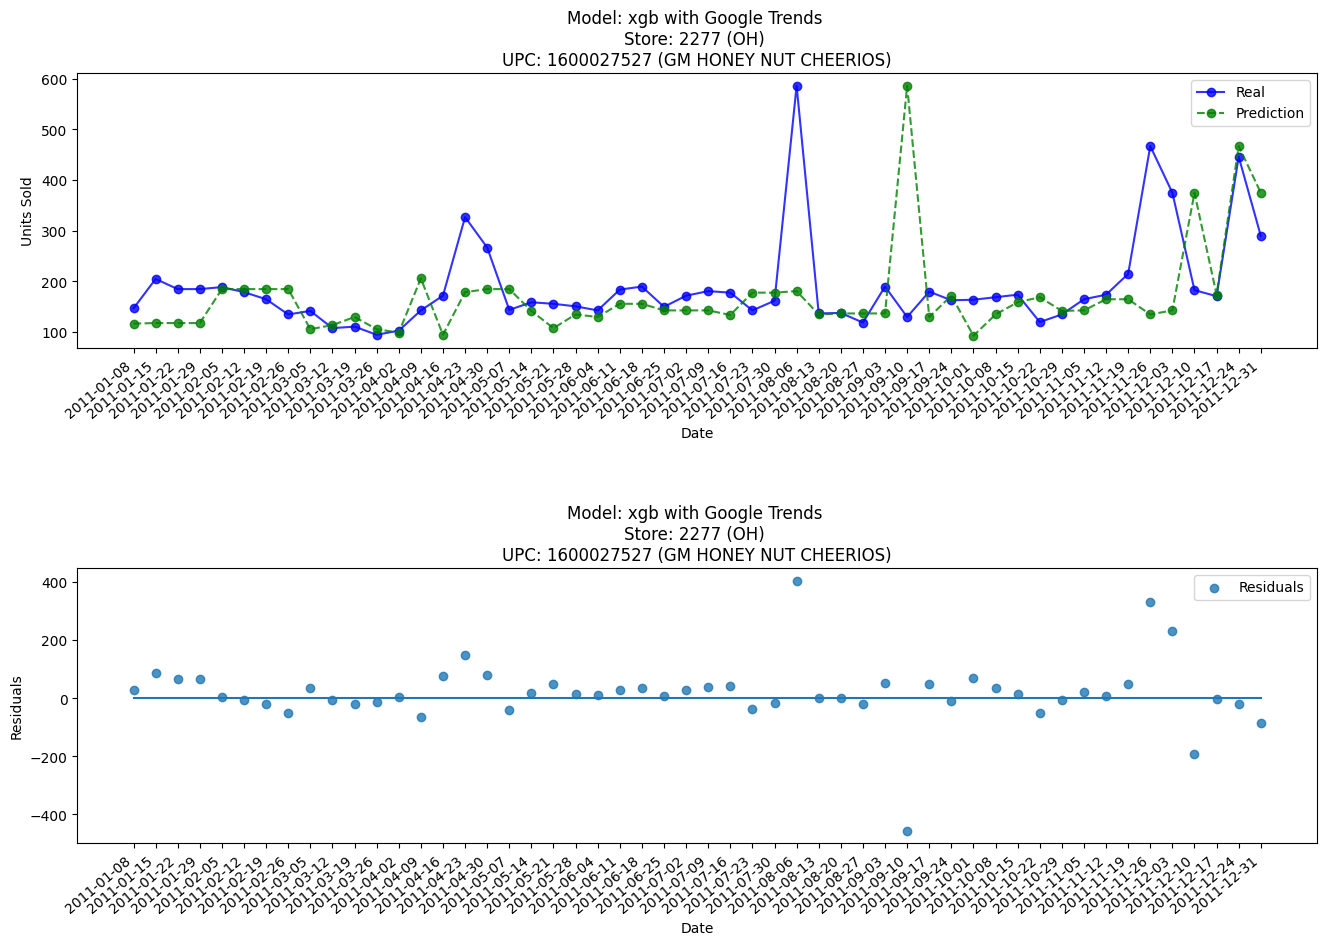

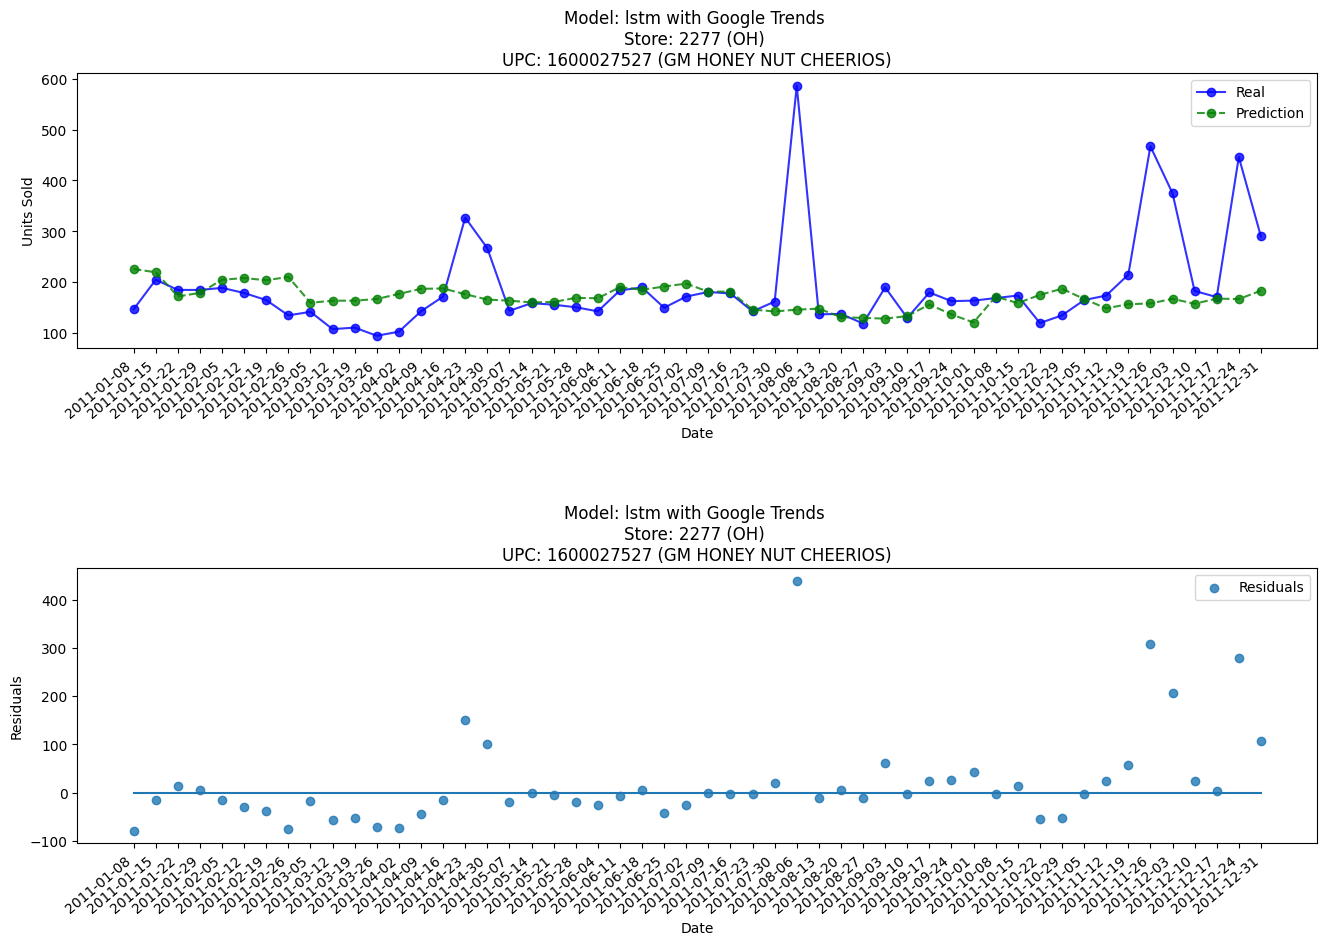

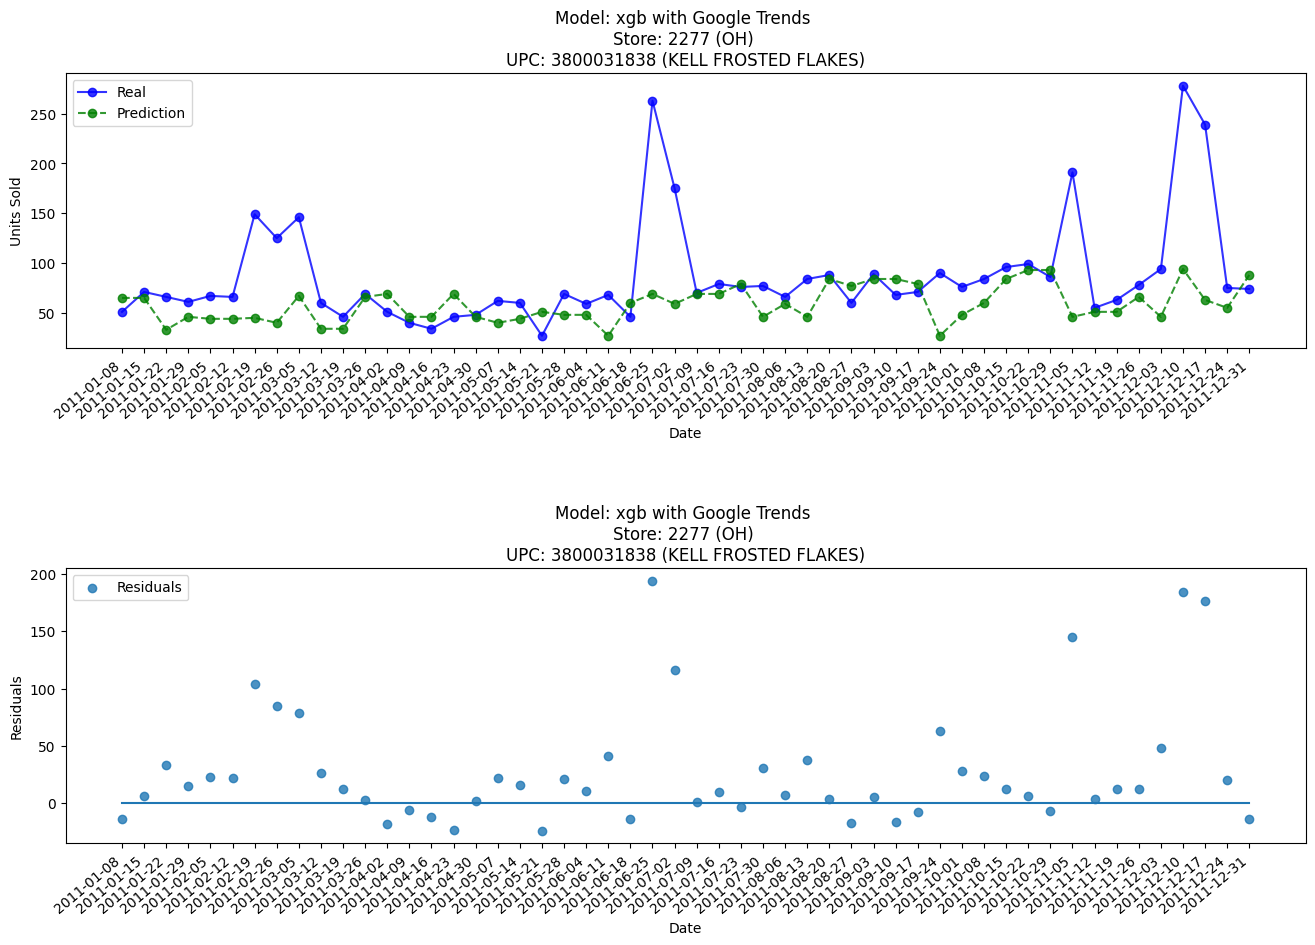

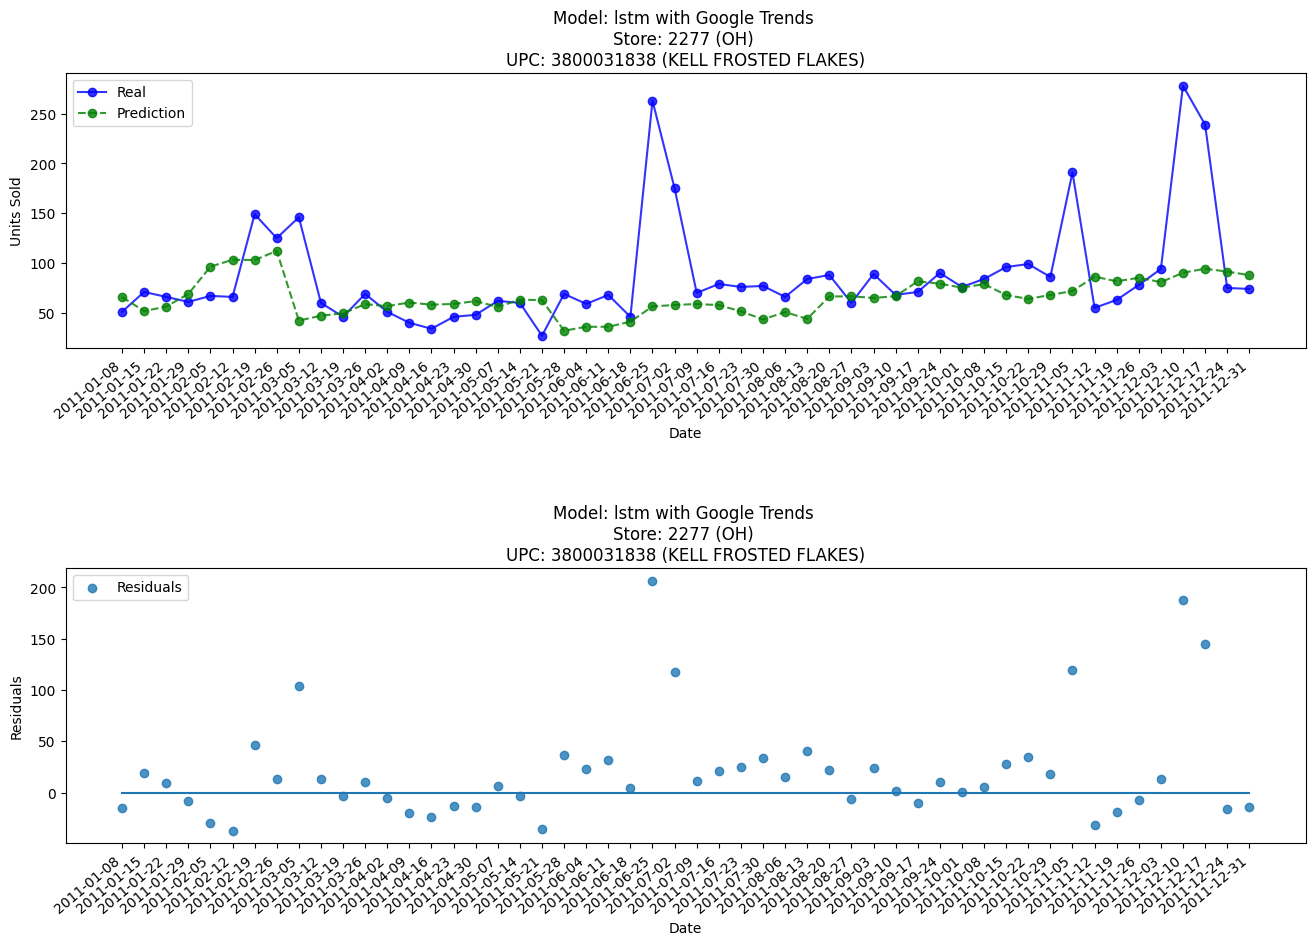

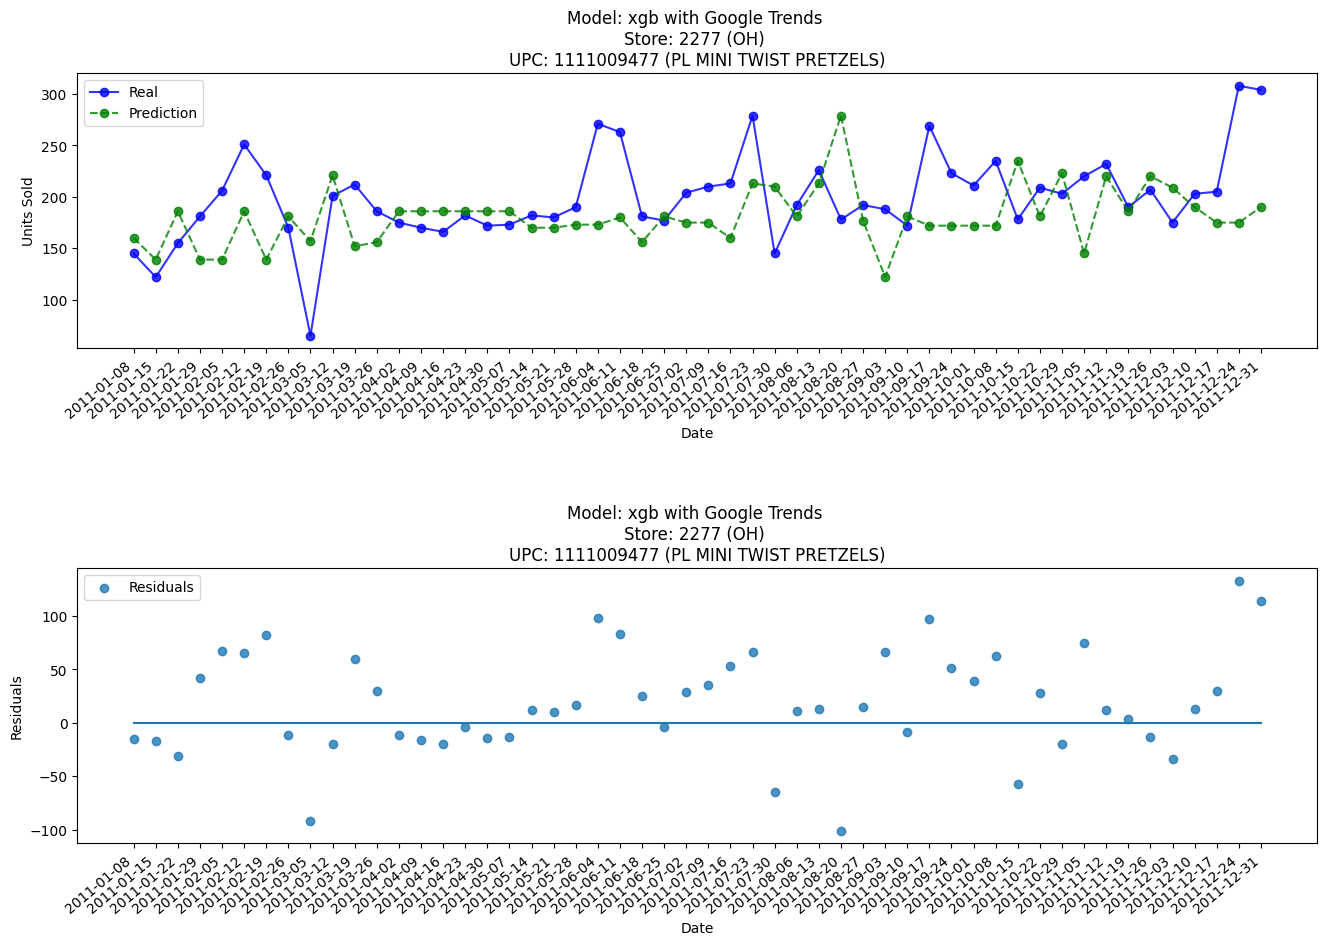

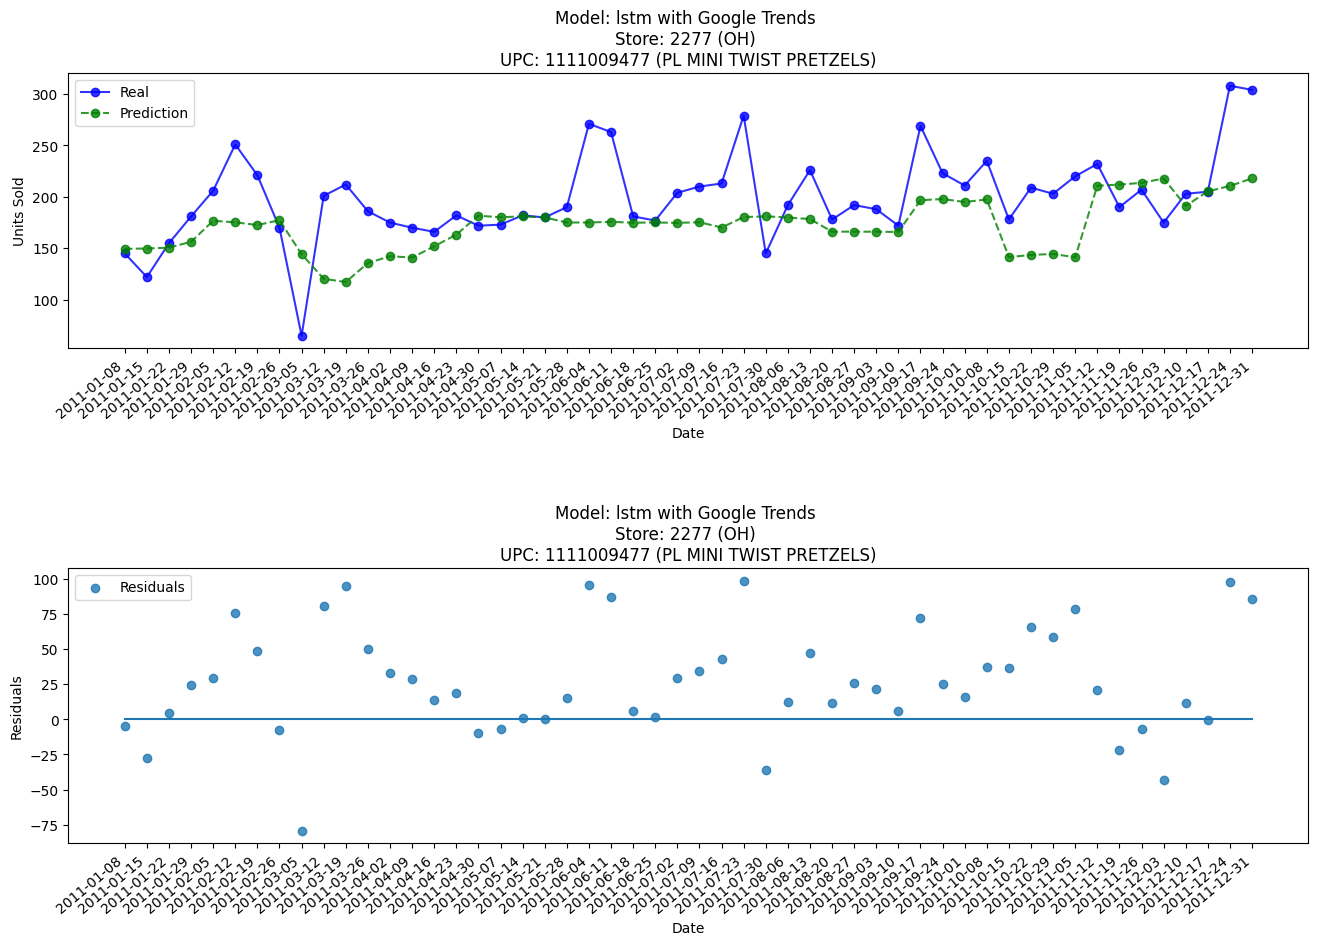

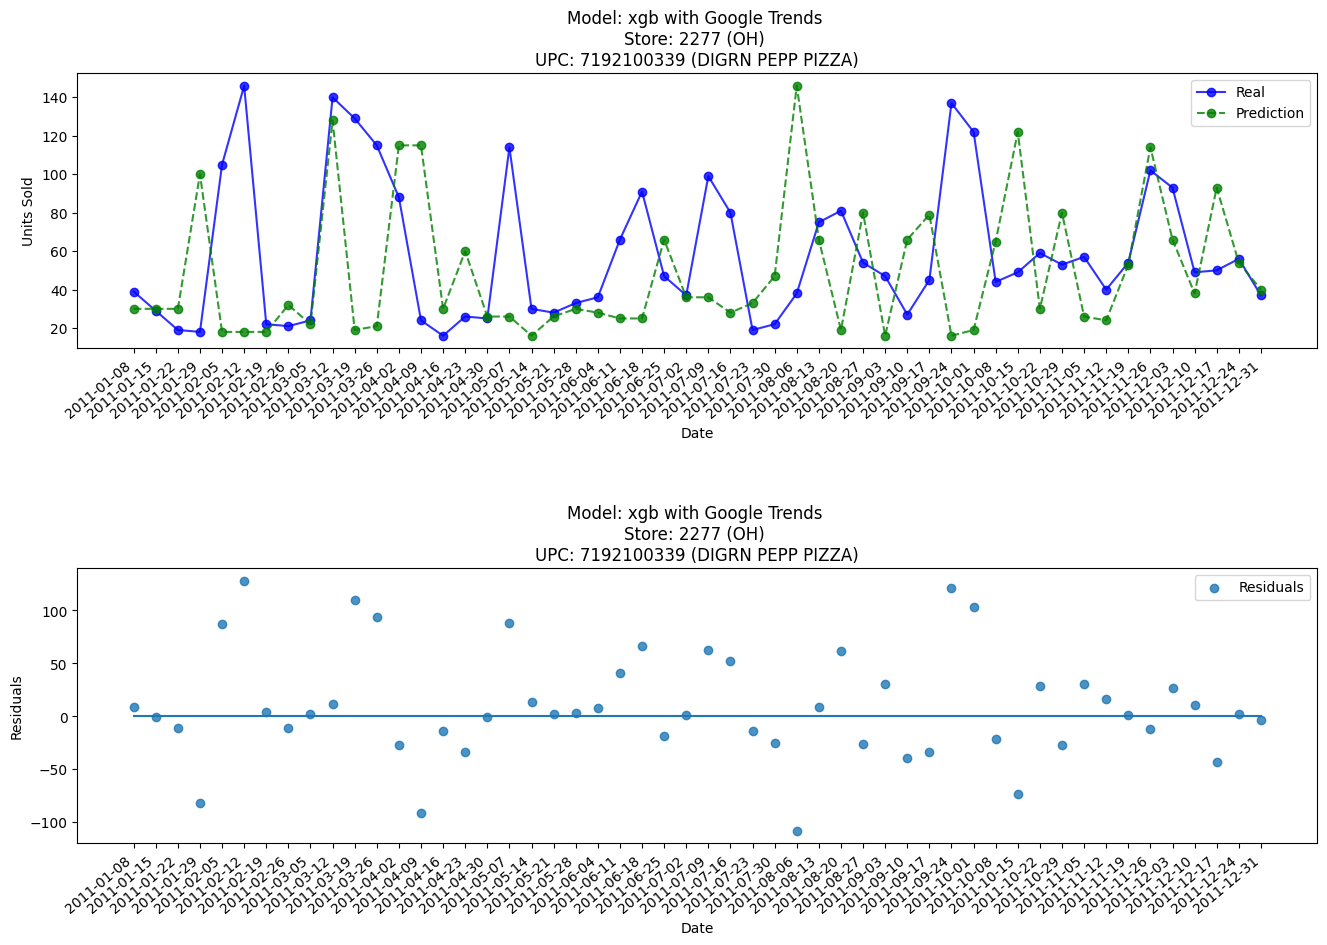

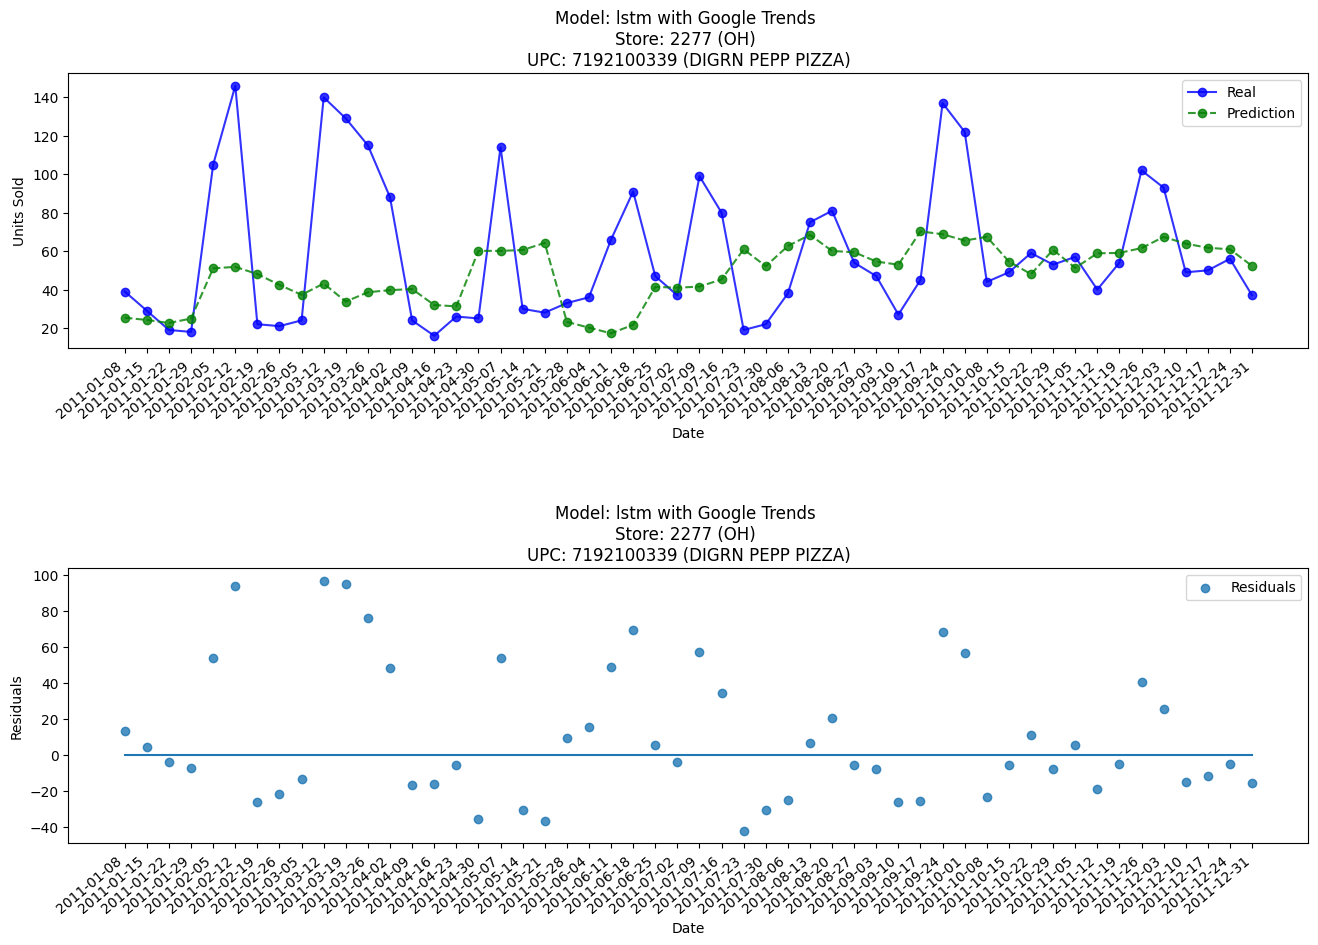

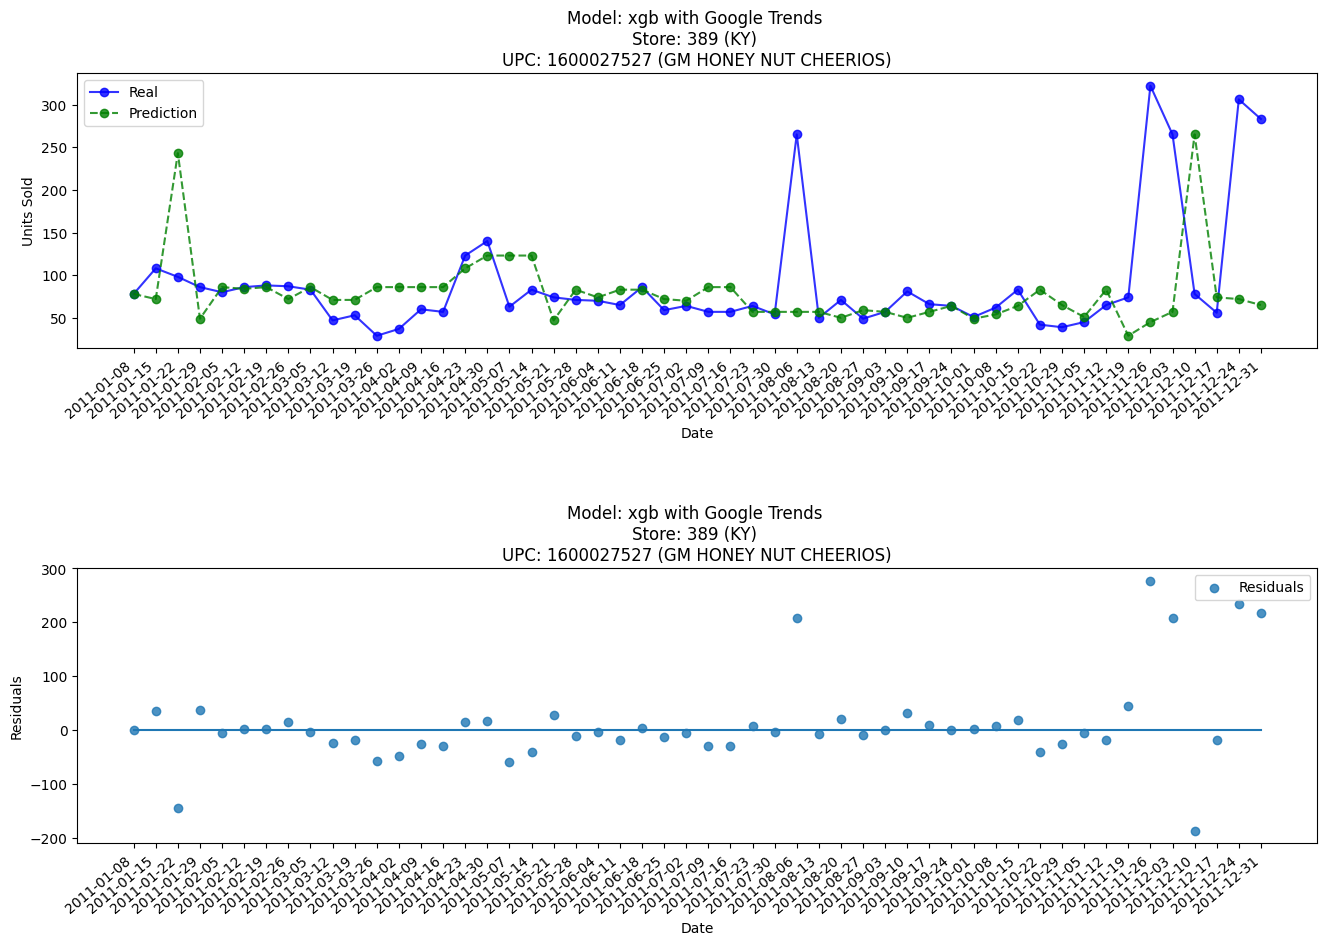

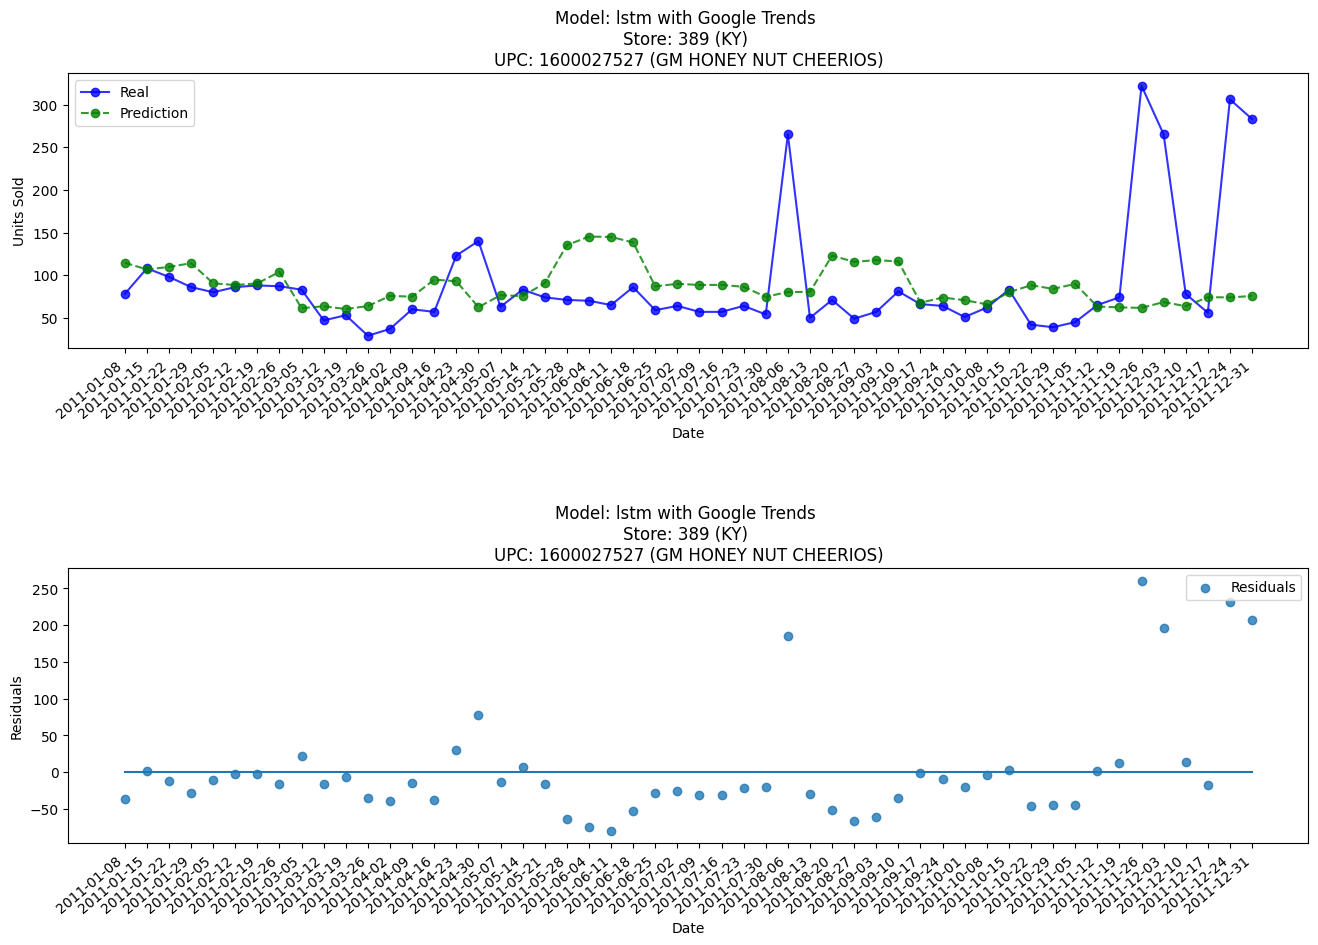

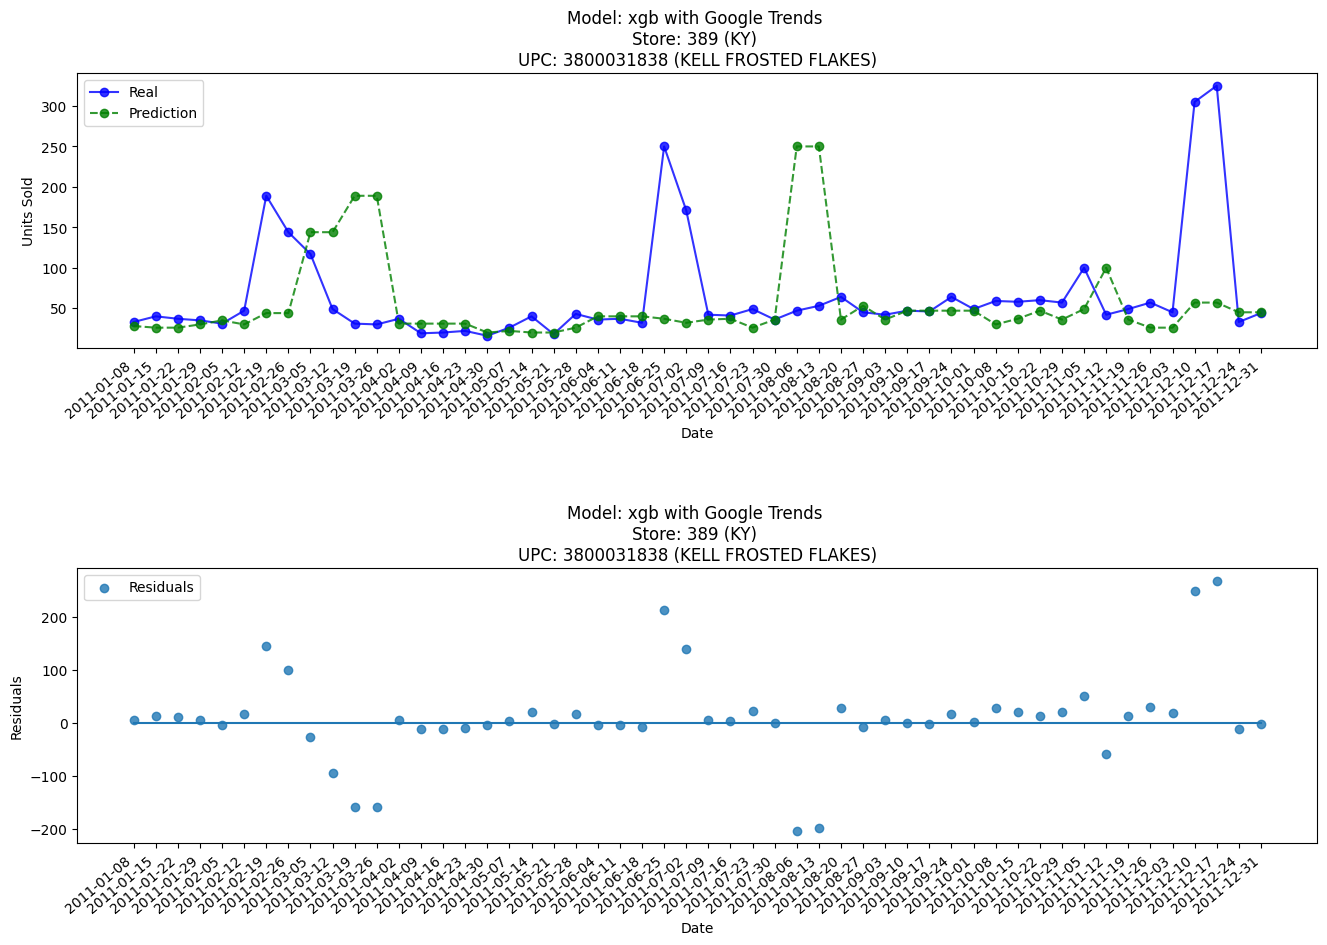

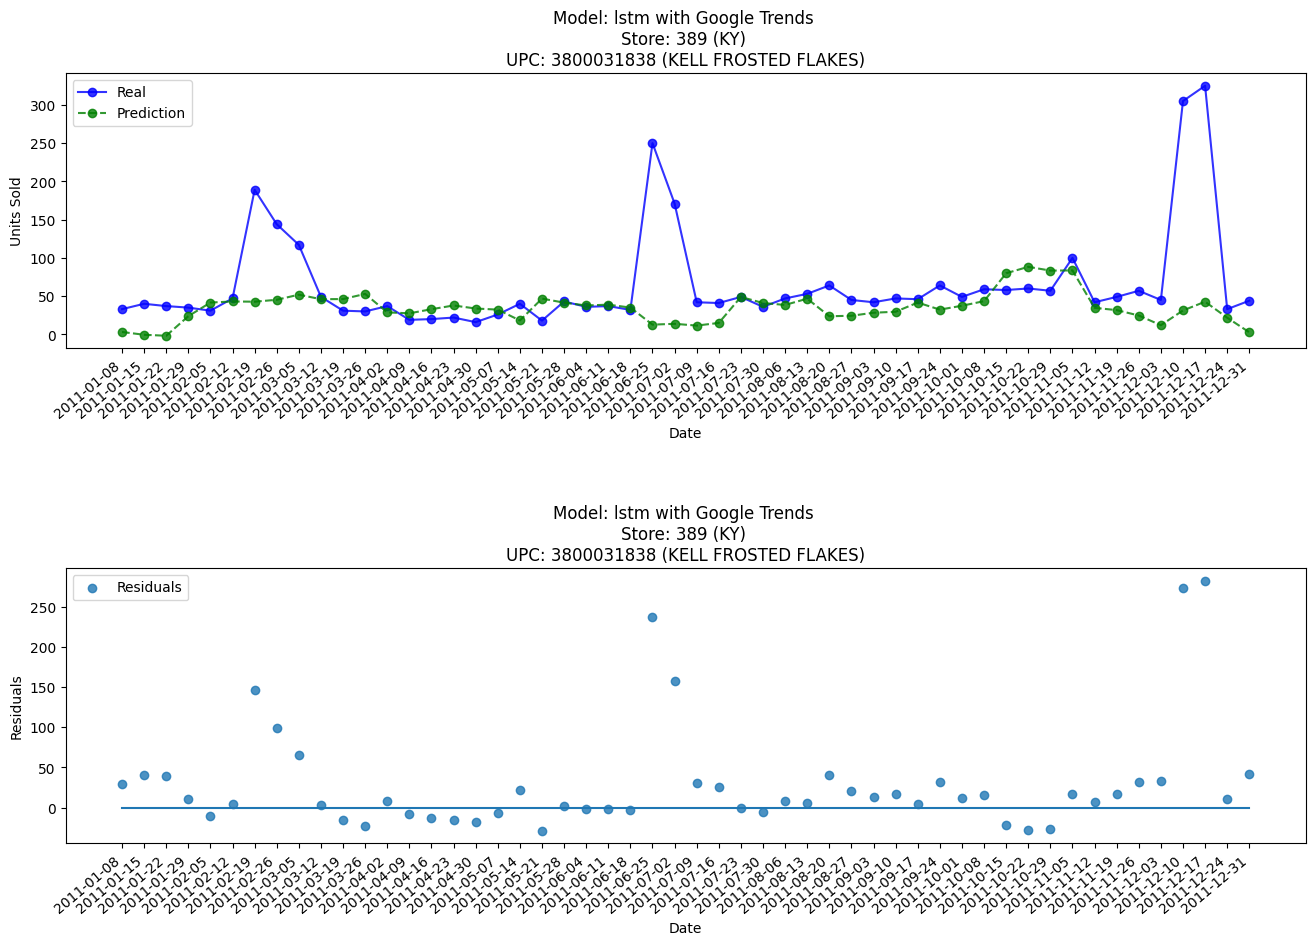

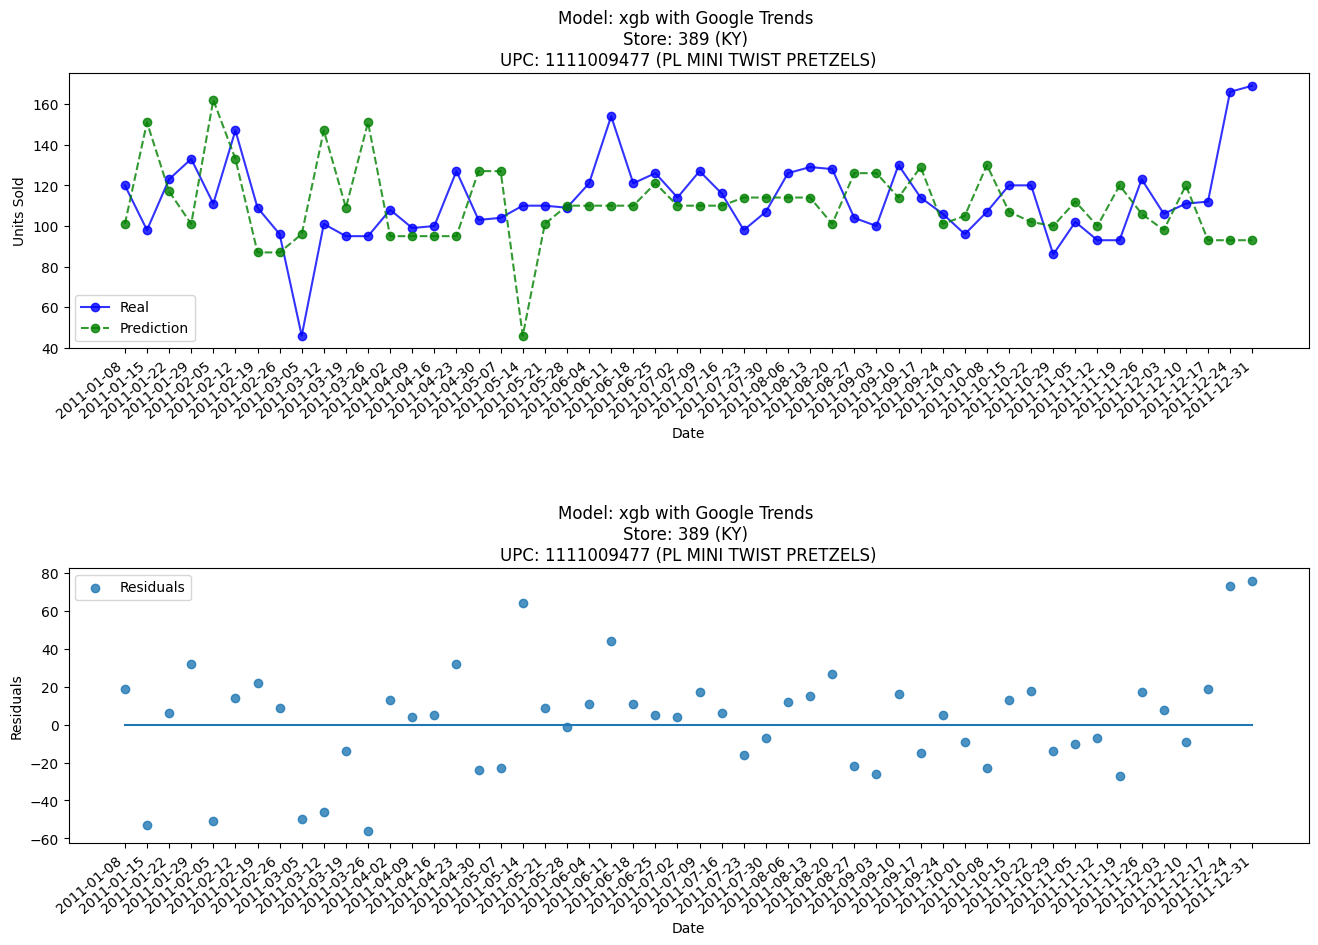

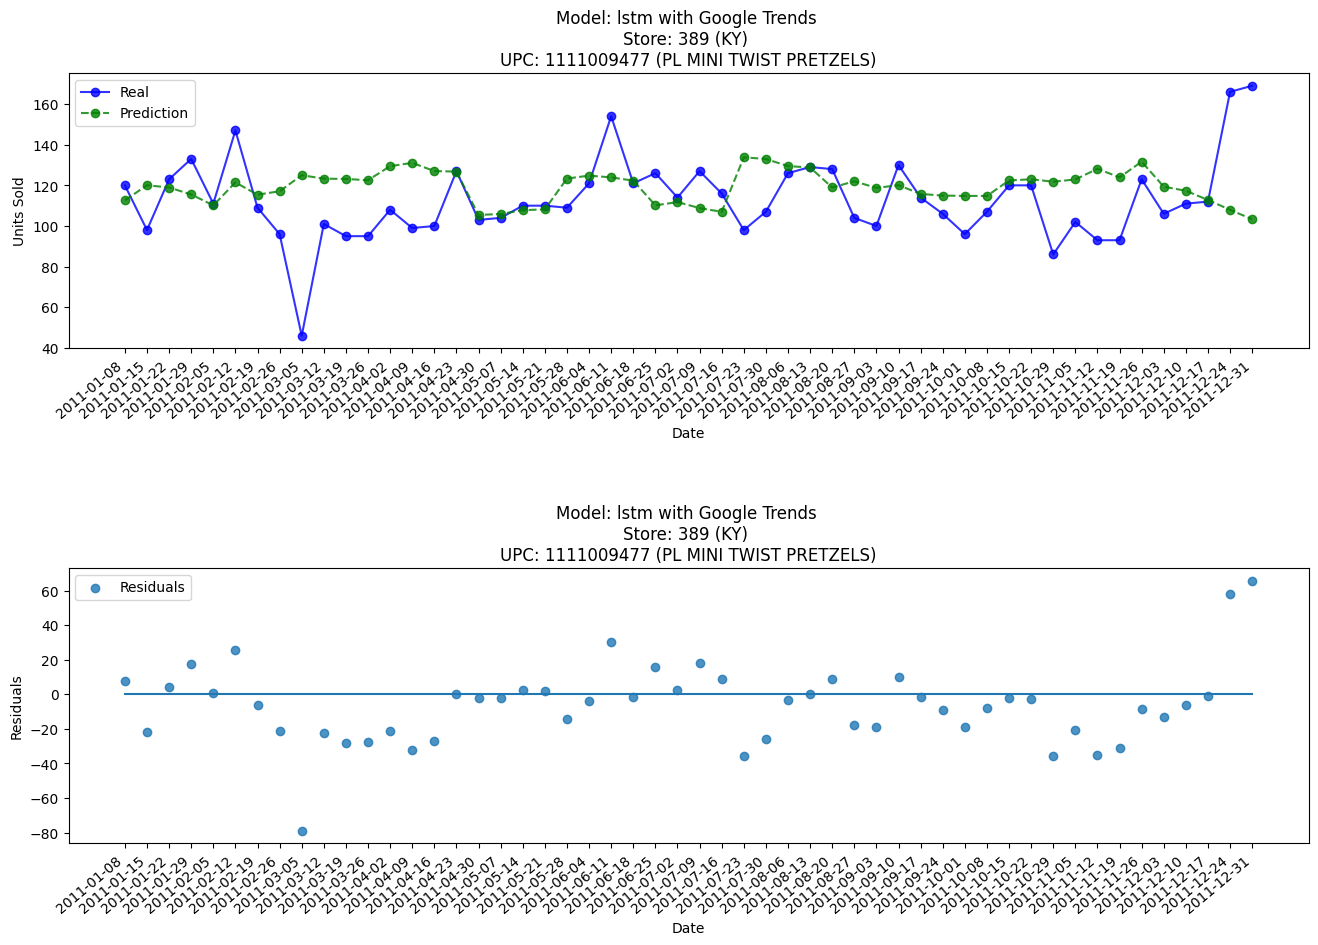

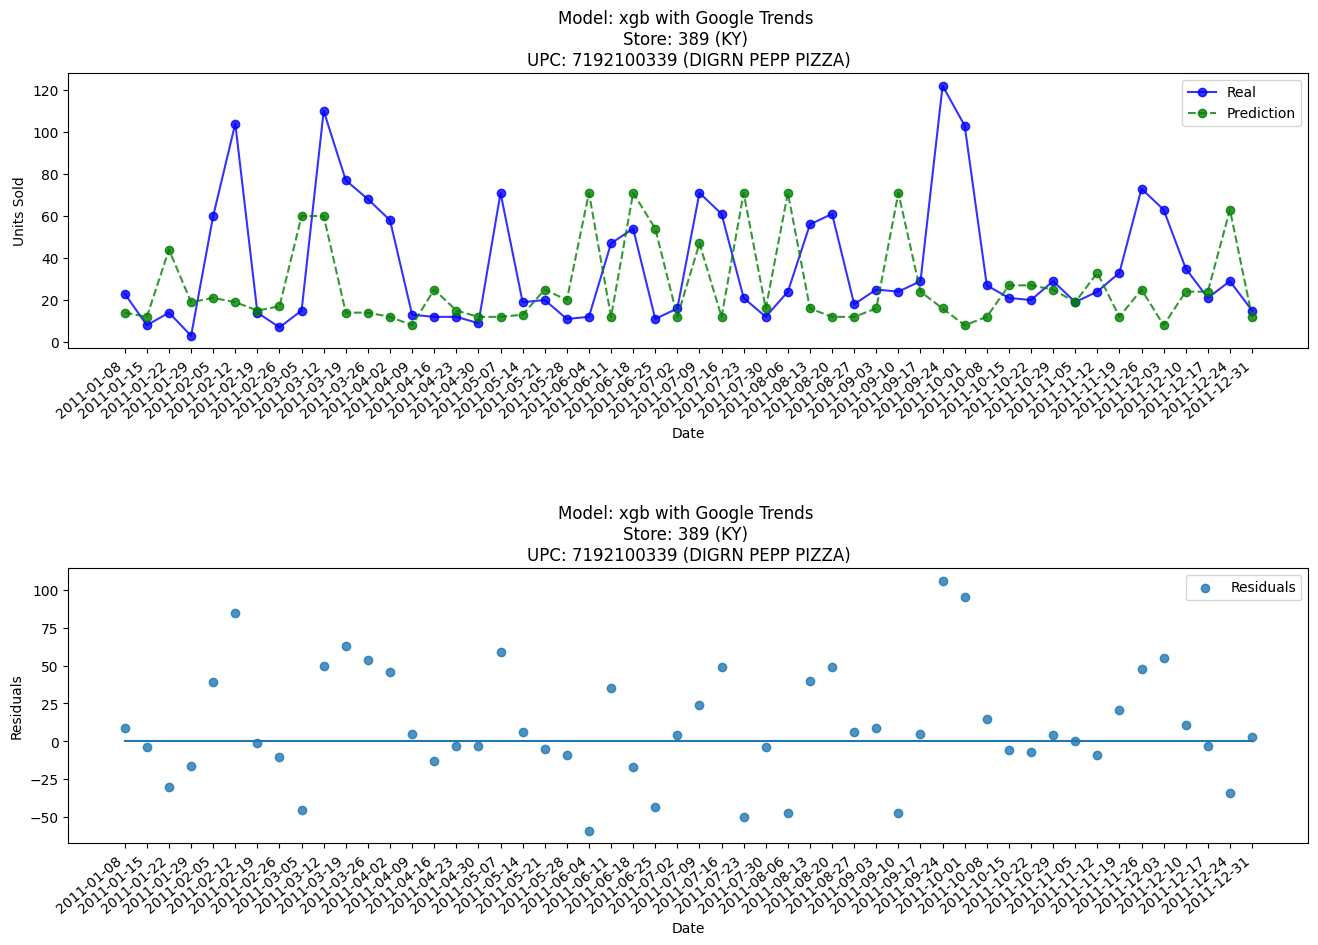

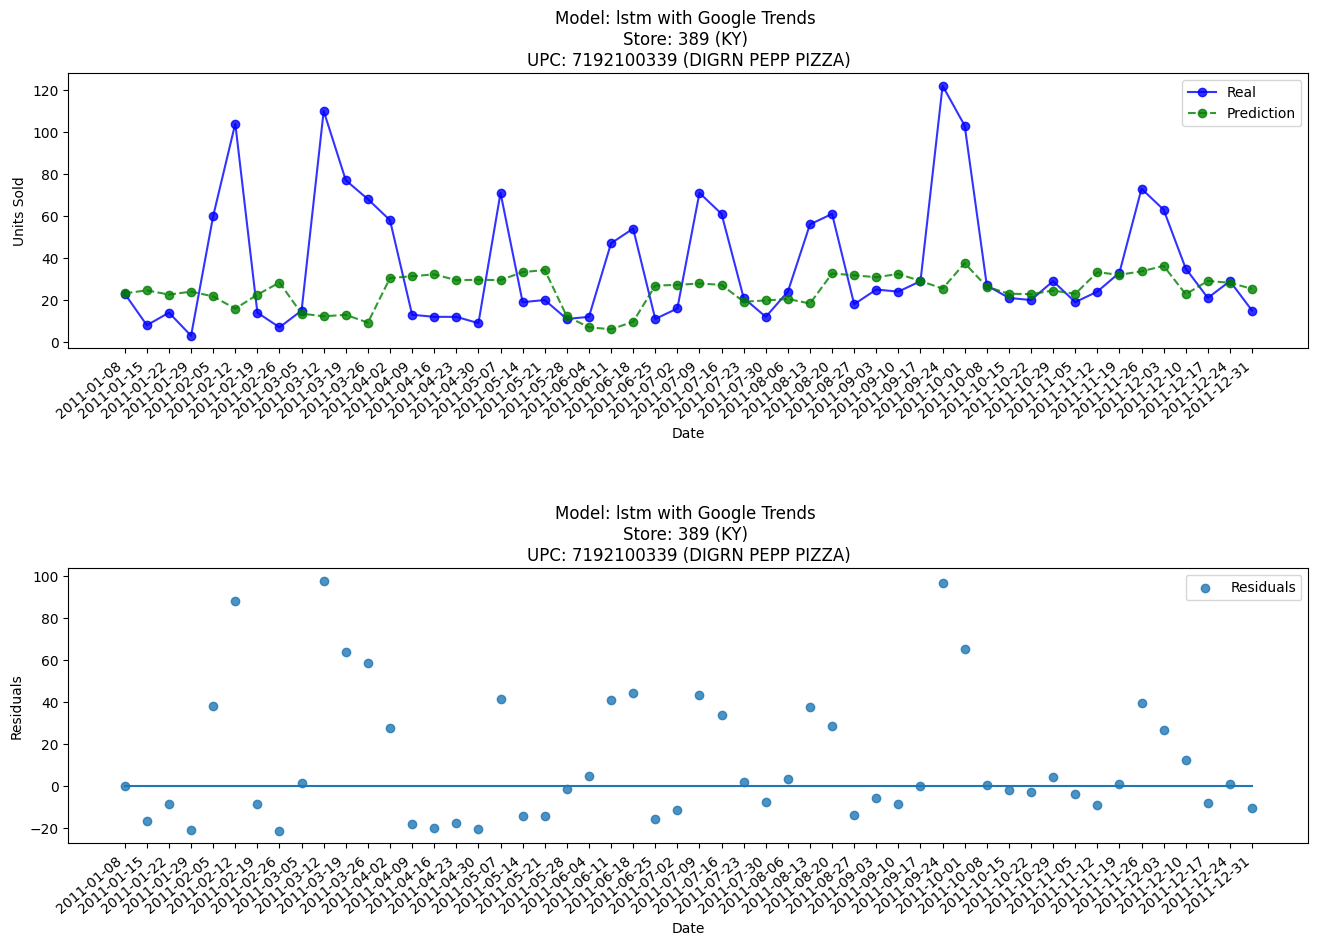

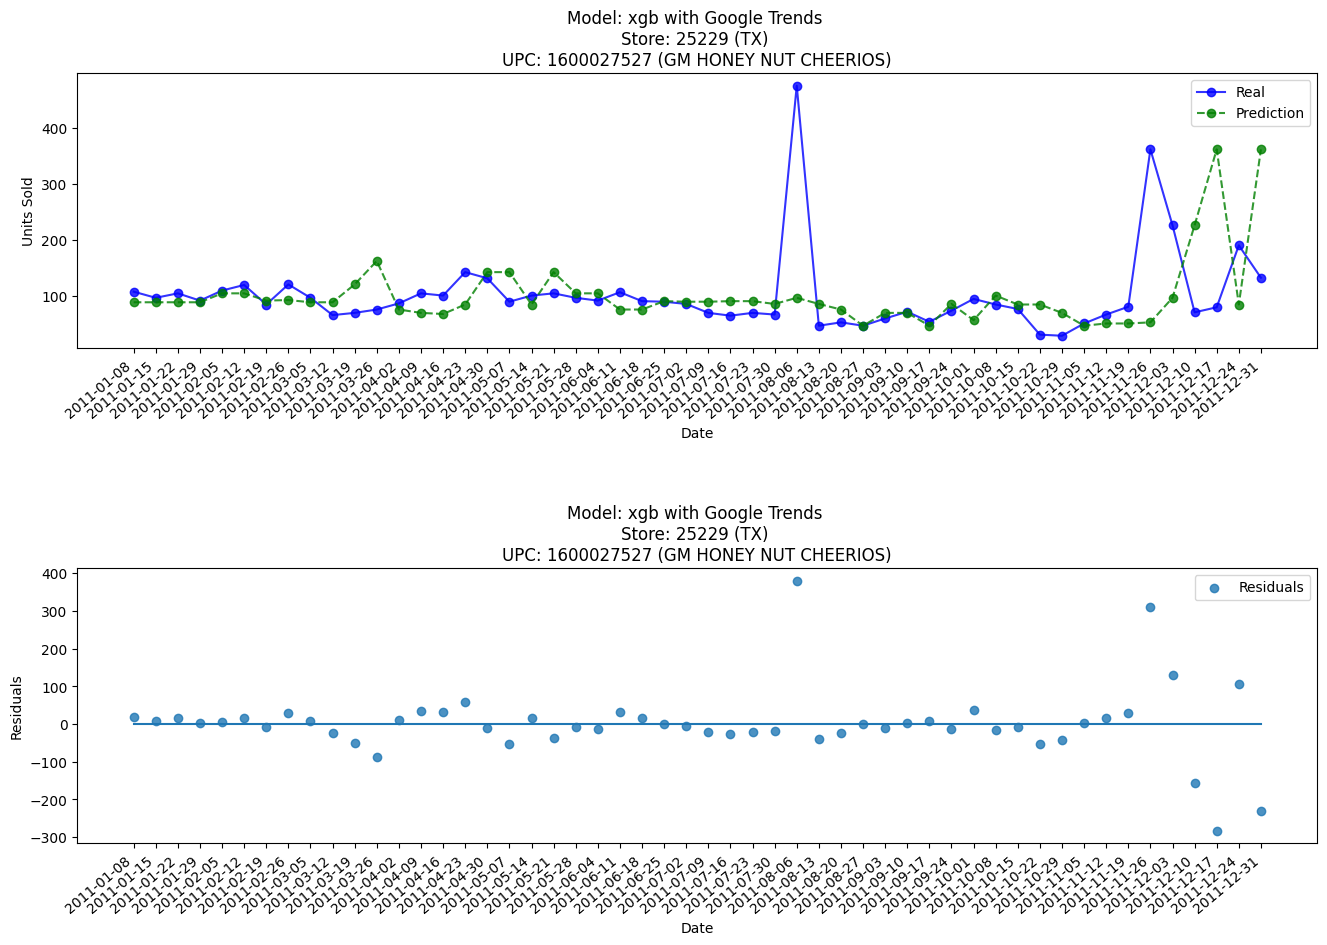

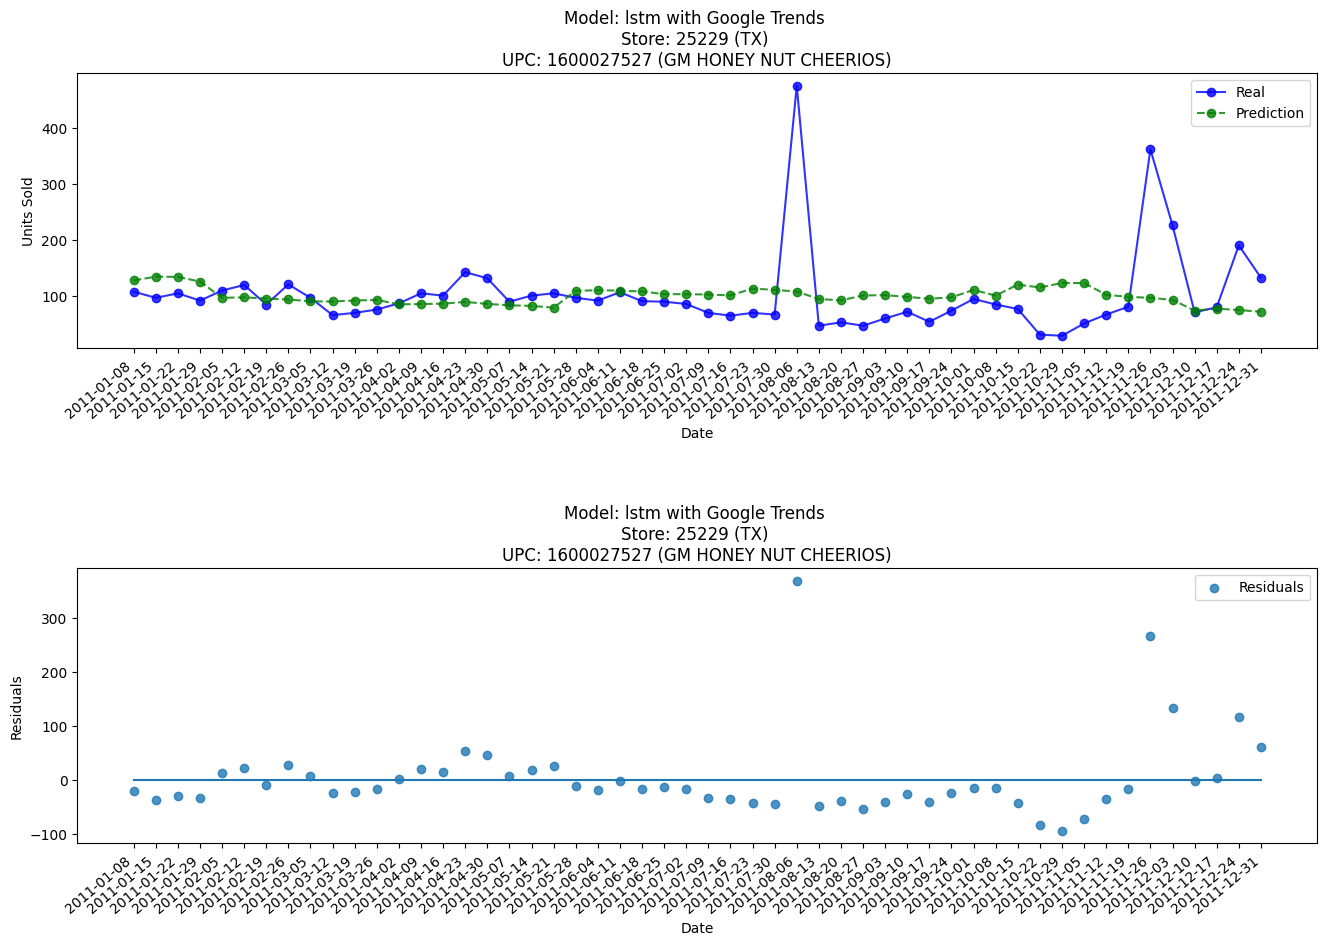

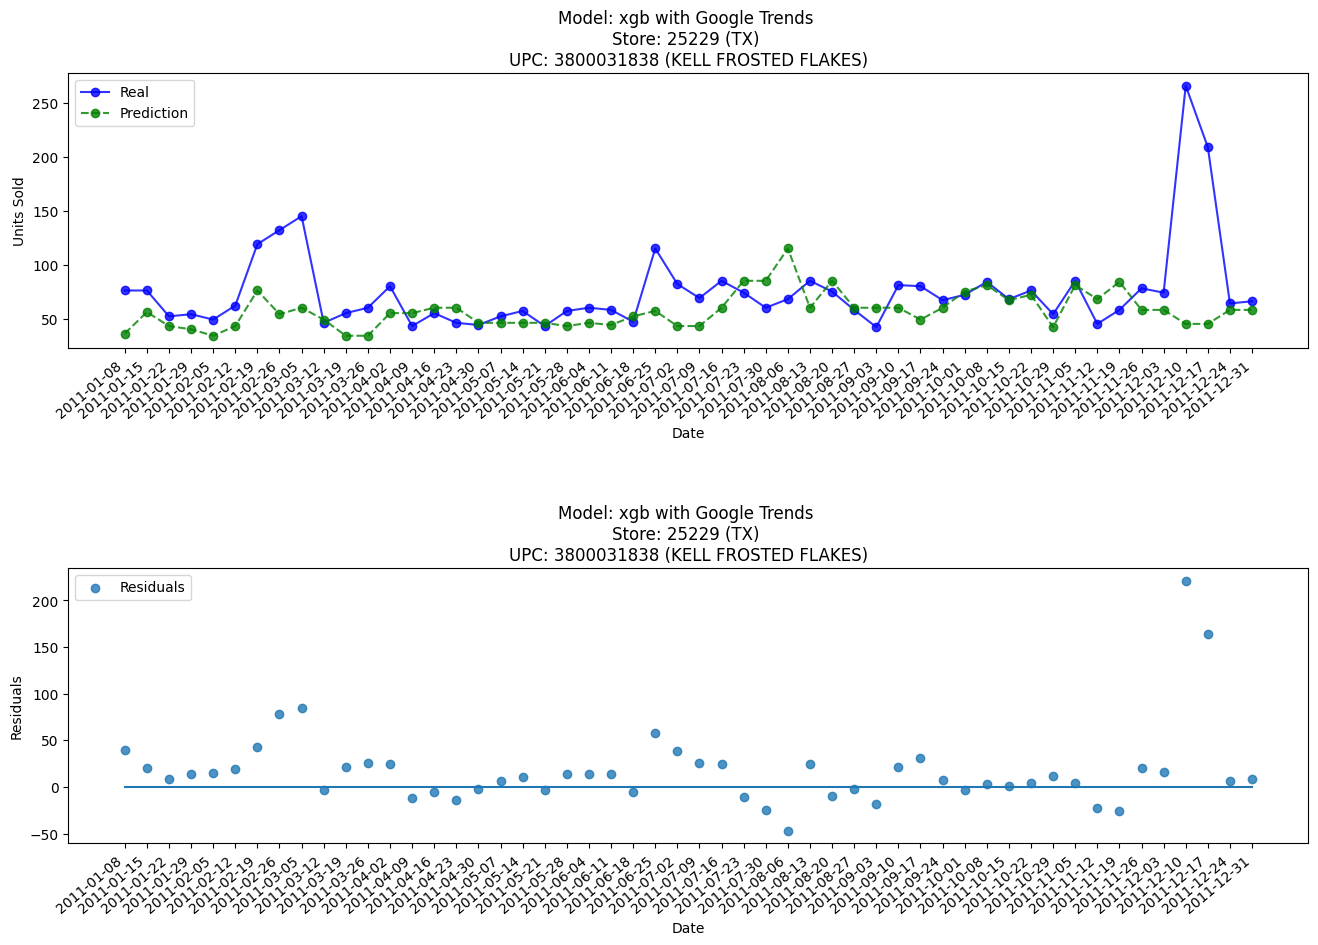

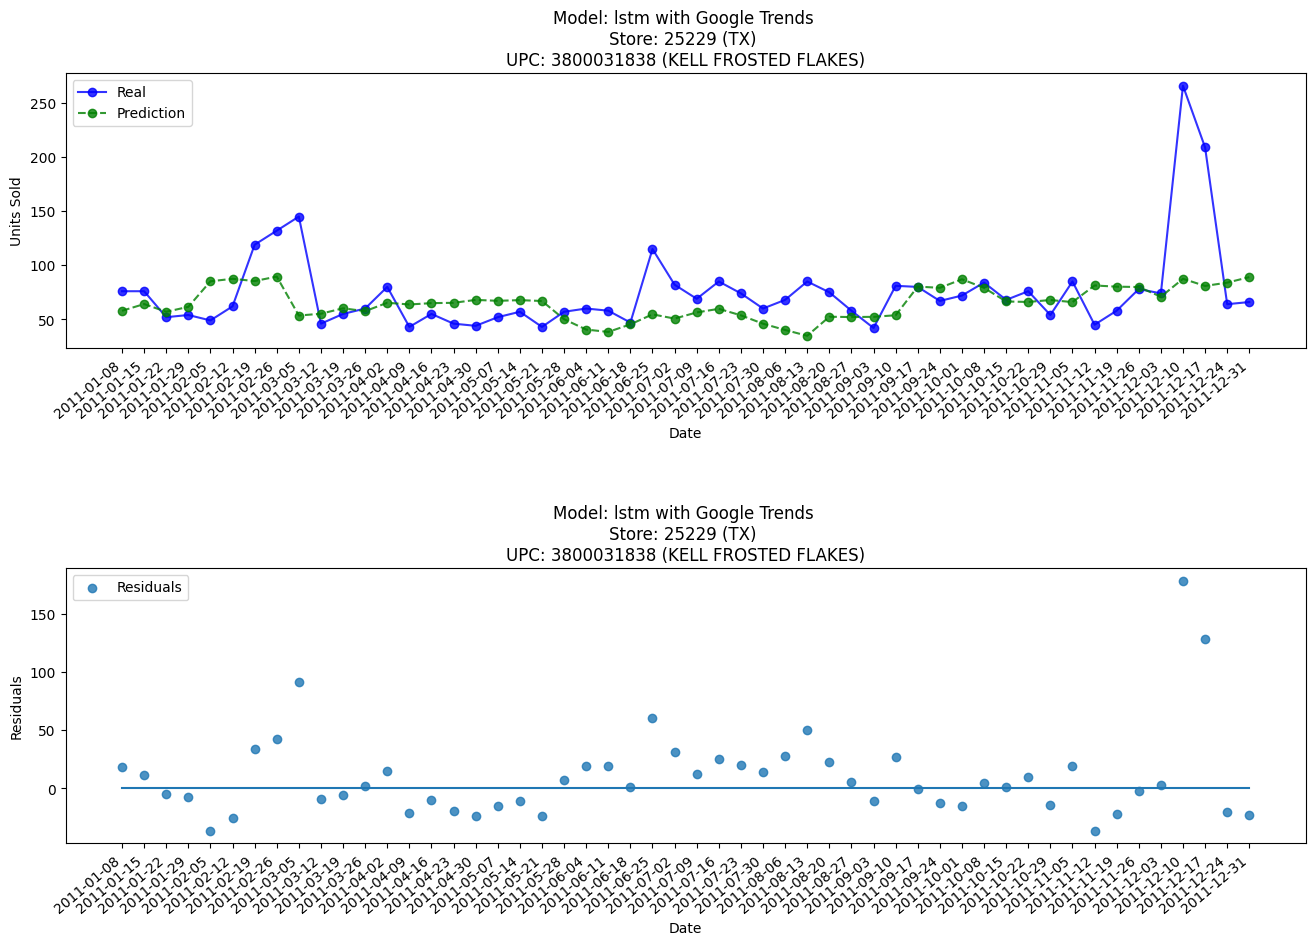

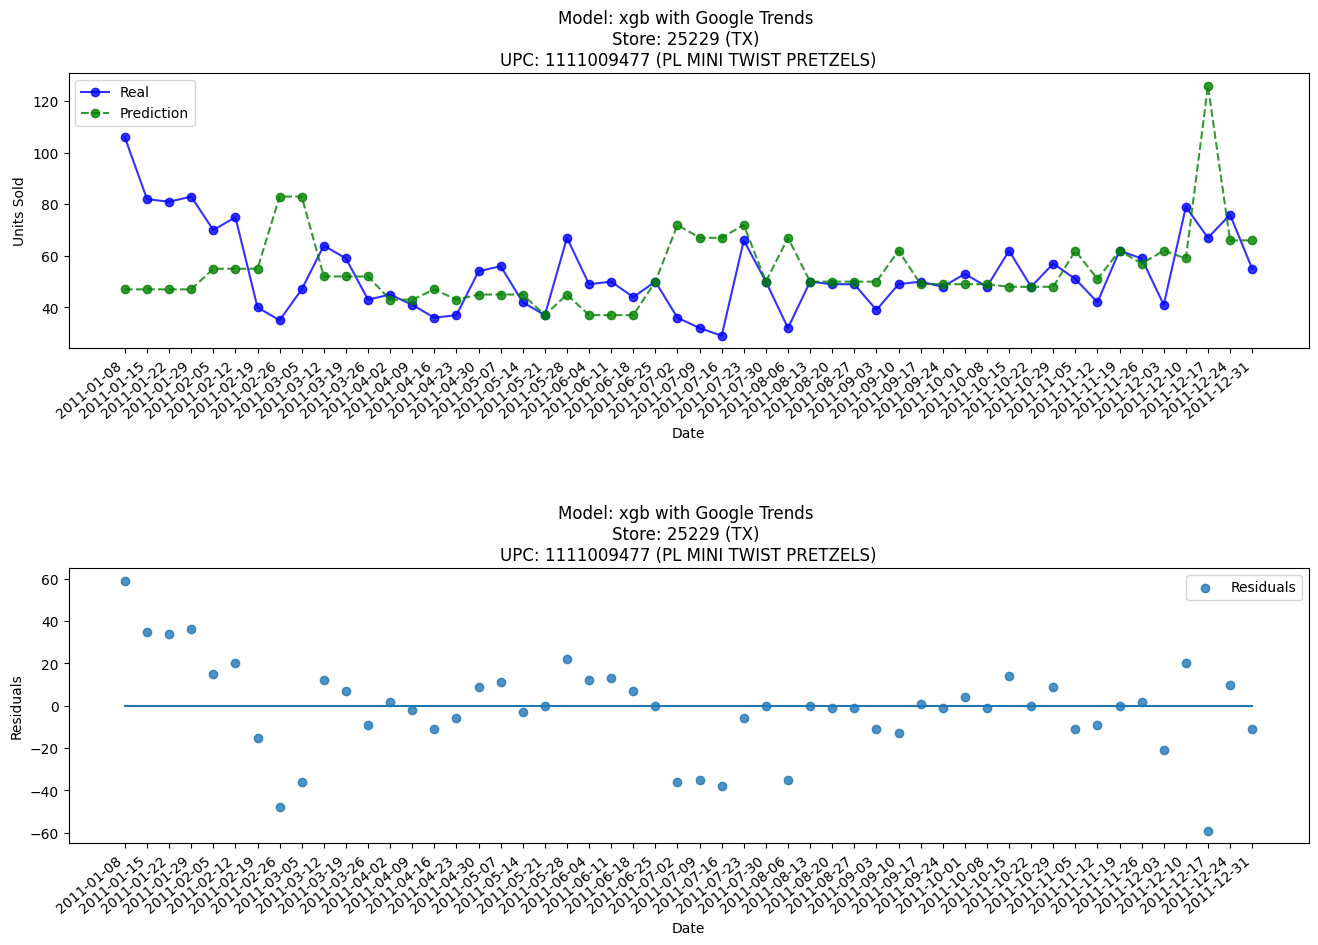

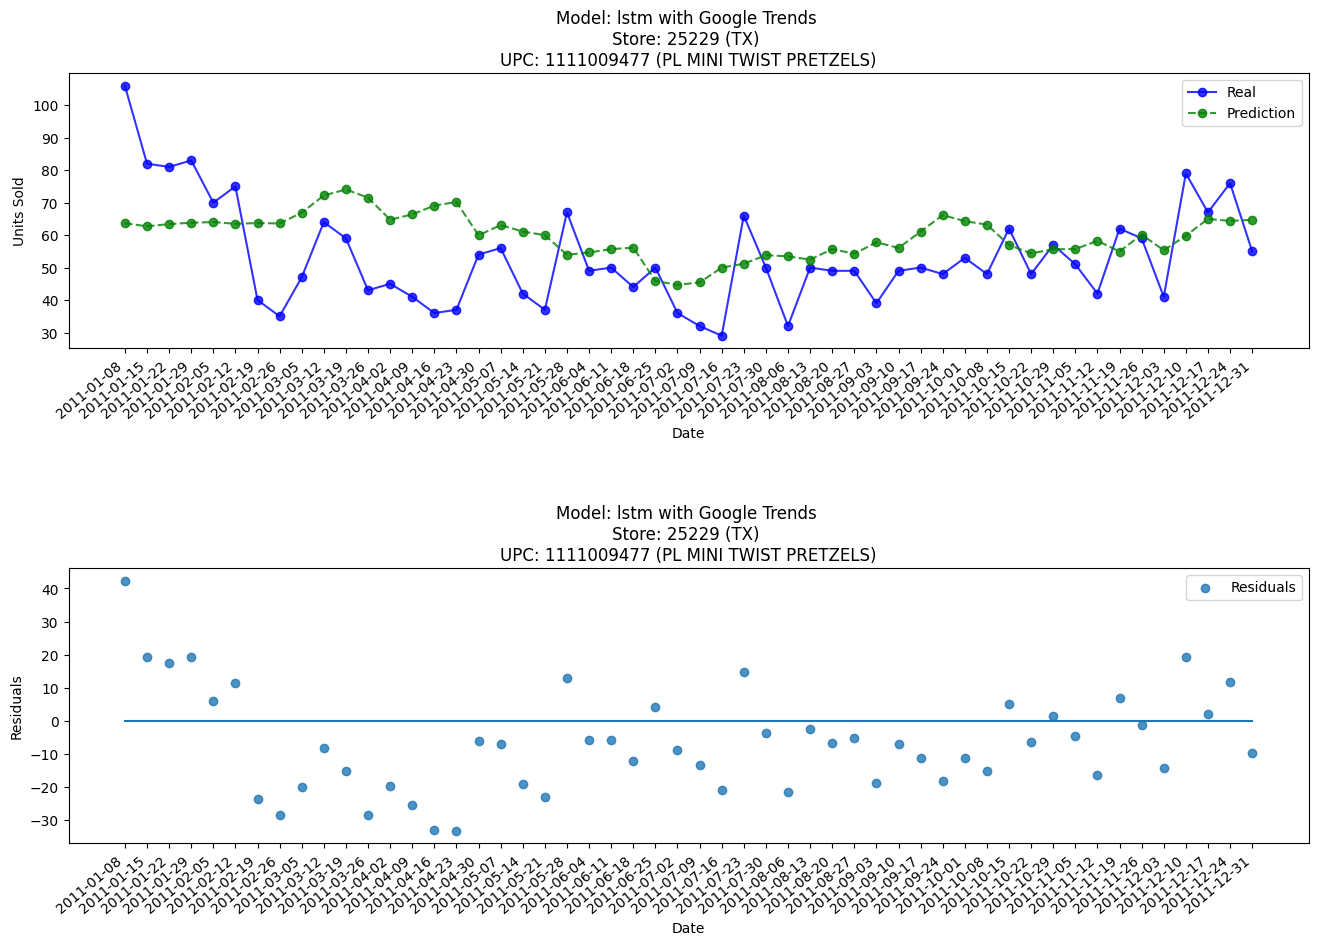

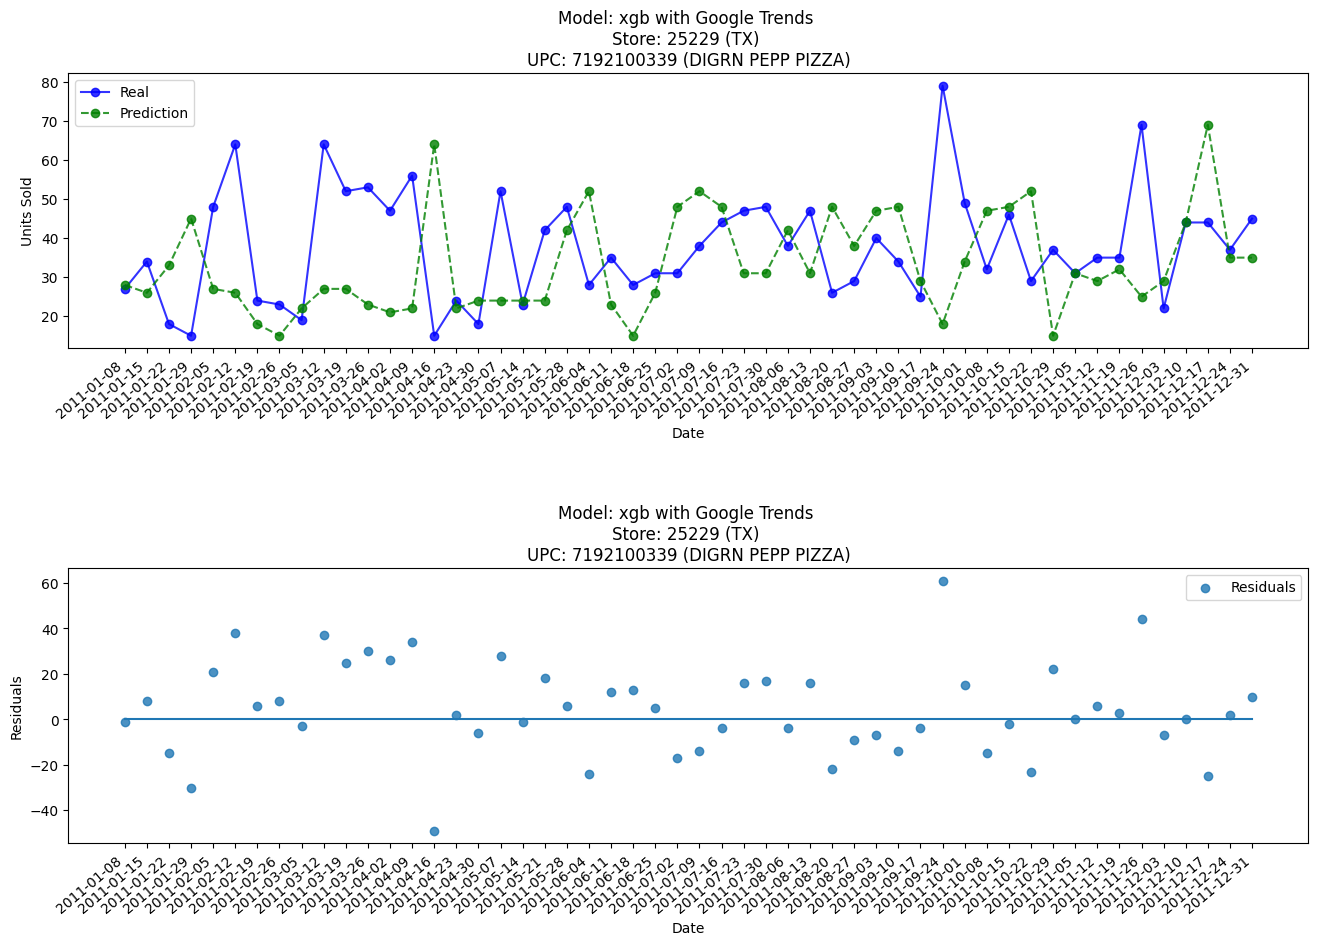

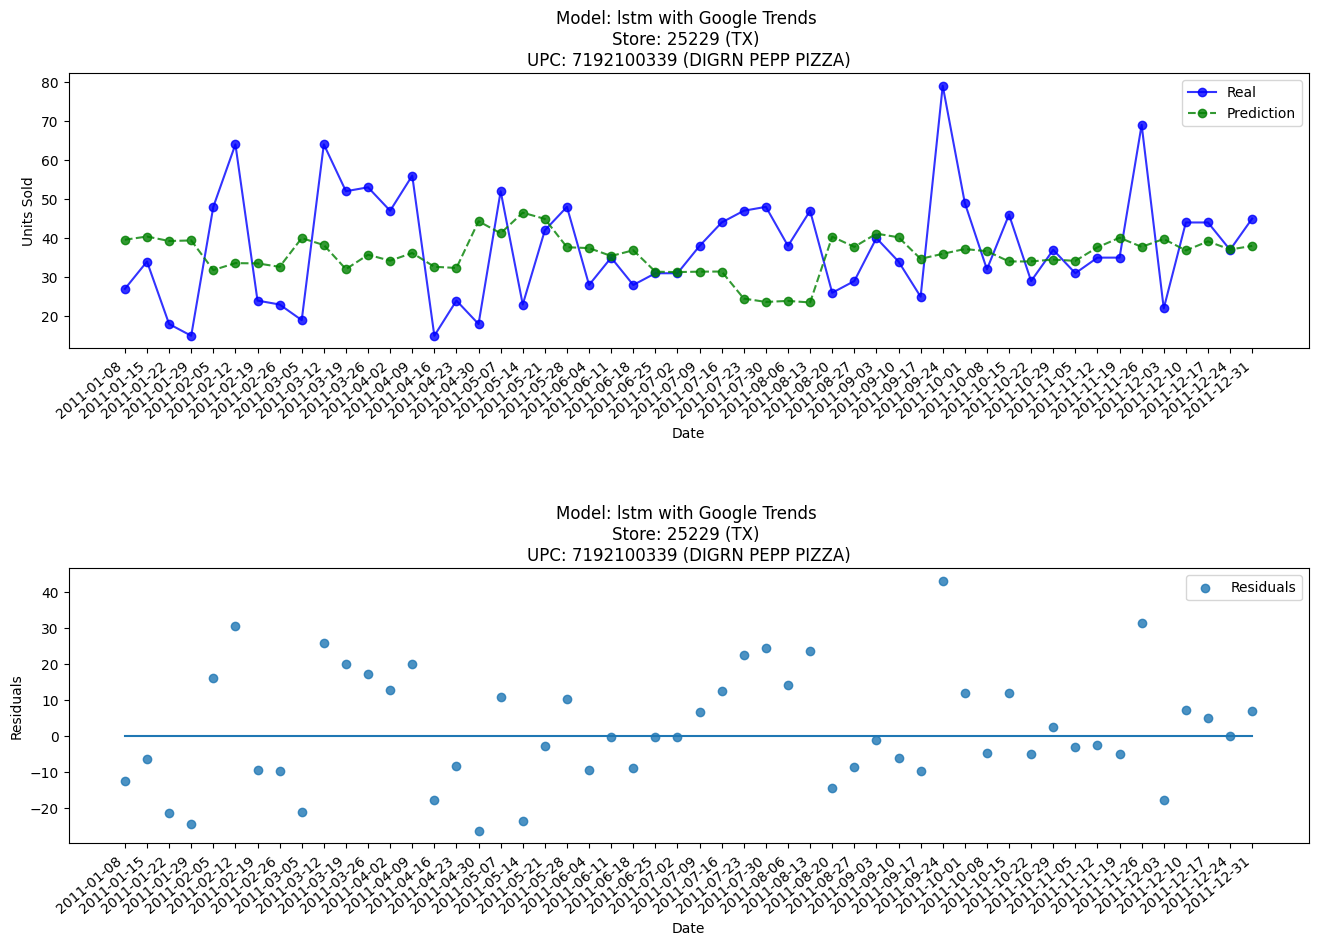

In [39]:
# Plot the forecast for each model (Only Google Trends)
for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        
        fig, axs = plt.subplots(2, 1, figsize=(16,10))
        plt.subplots_adjust(hspace=0.8)
        
        # Forecast
        axs[0].plot(temp['y_true'], 'b-o', label='Real',alpha=0.8)
        axs[0].plot(temp[f'y_pred_{model}_gtrend'], 'g--o', label='Prediction',alpha=0.8)
        axs[0].set_title(f'Model: {model} with Google Trends \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Units Sold')
        axs[0].legend()
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        # Residuals
        axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}_gtrend']), marker='o', label='Residuals', alpha=0.8)
        axs[1].plot([0]*temp.shape[0])
        axs[1].set_title(f'Model: {model} with Google Trends \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Residuals')
        axs[1].legend()
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        plt.show()
        
    print('\n\n\n')

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


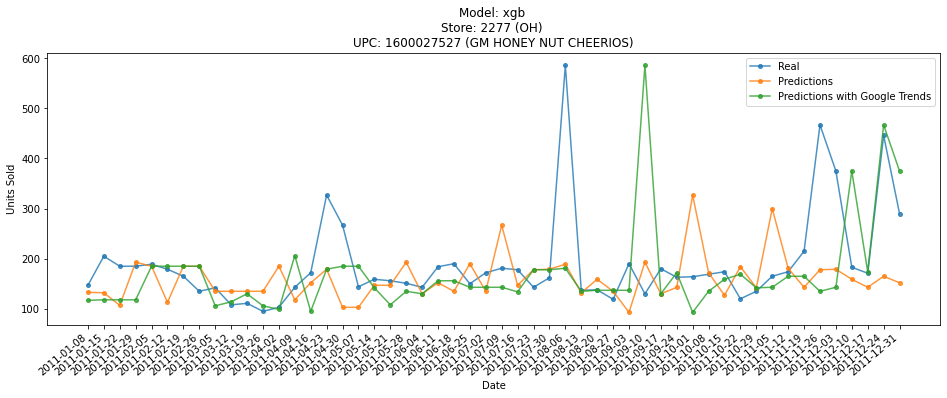

Std xgb: 43.96 and with Google Trends: 89.77


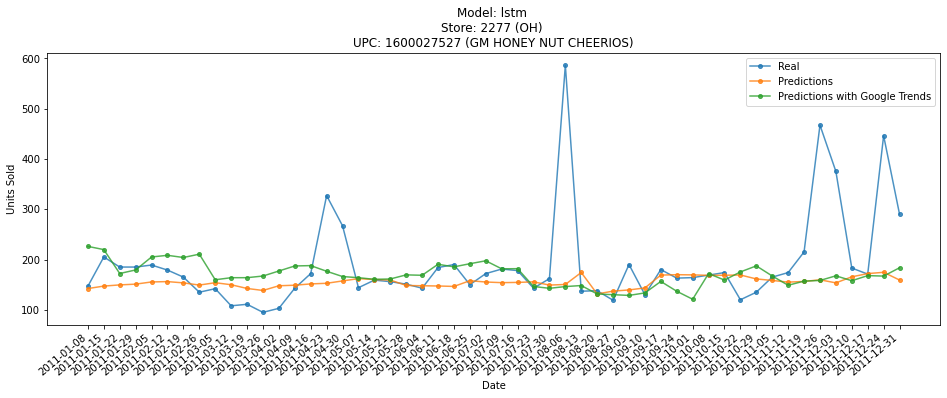

Std lstm: 9.84 and with Google Trends: 23.49






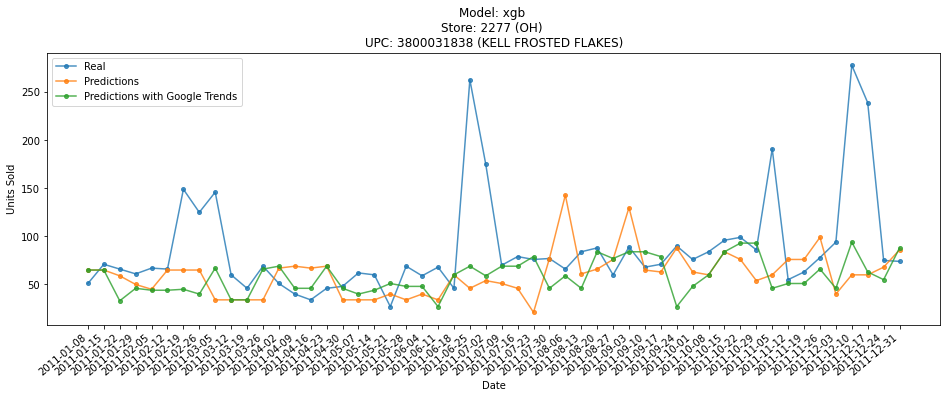

Std xgb: 22.95 and with Google Trends: 17.84


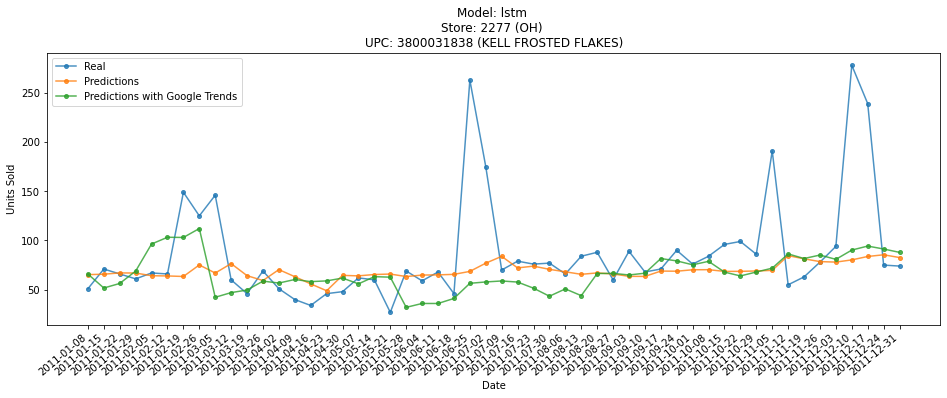

Std lstm: 7.48 and with Google Trends: 18.52






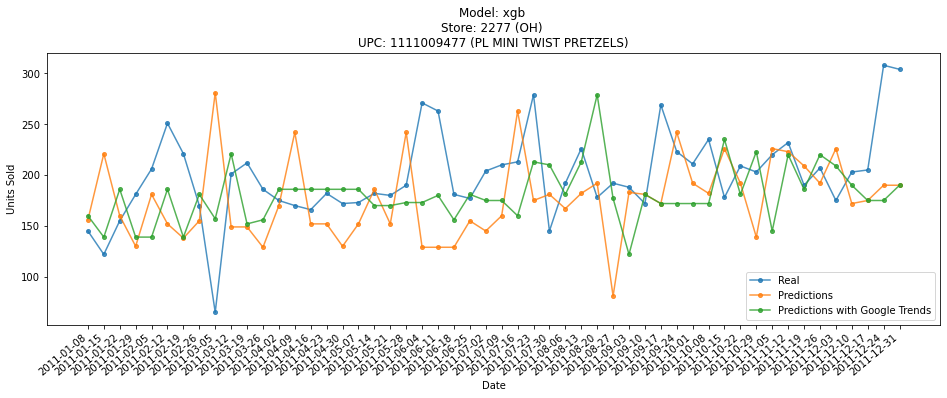

Std xgb: 39.19 and with Google Trends: 27.73


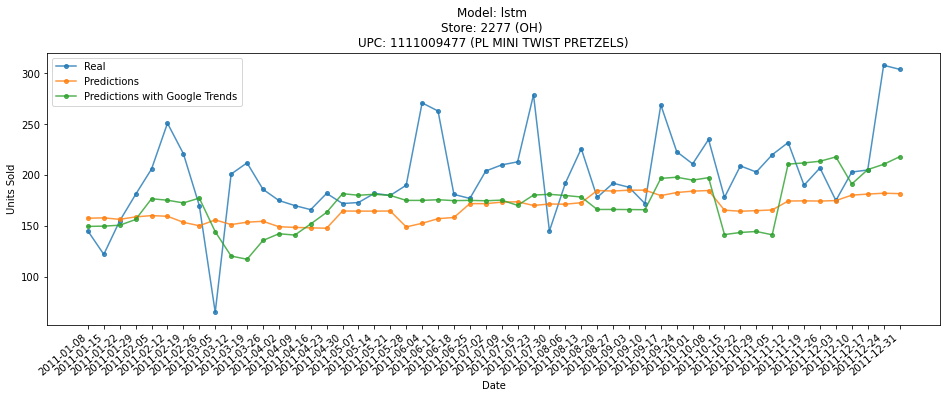

Std lstm: 11.98 and with Google Trends: 24.46






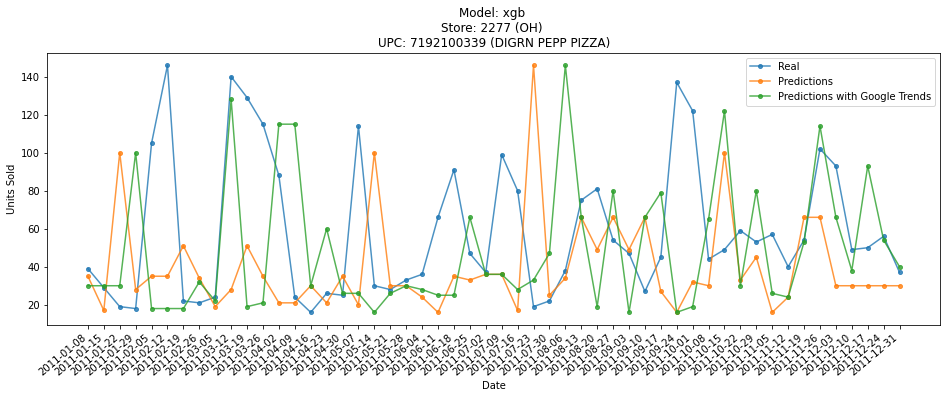

Std xgb: 25.46 and with Google Trends: 34.65


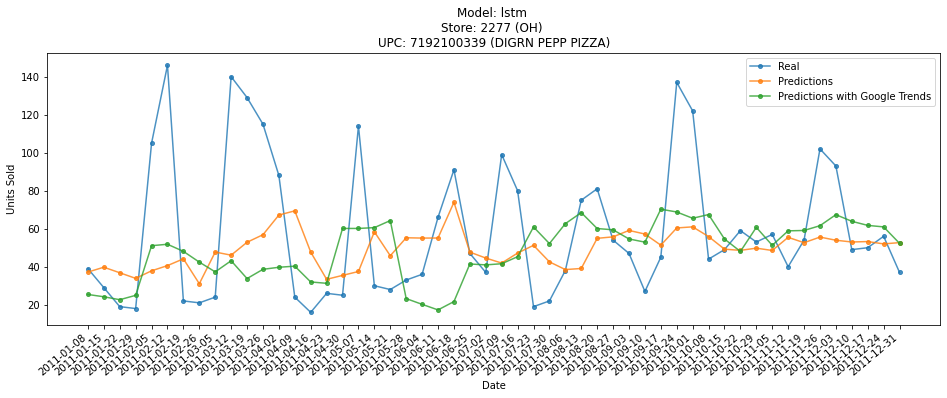

Std lstm: 9.34 and with Google Trends: 15.14






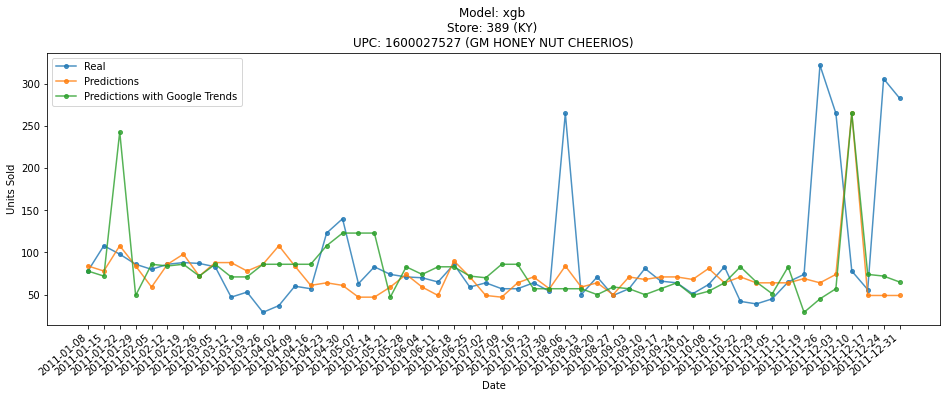

Std xgb: 31.03 and with Google Trends: 40.42


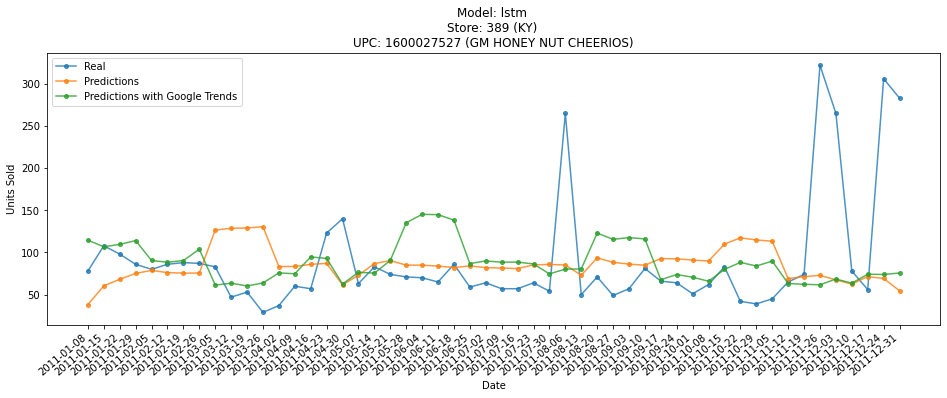

Std lstm: 19.00 and with Google Trends: 22.86






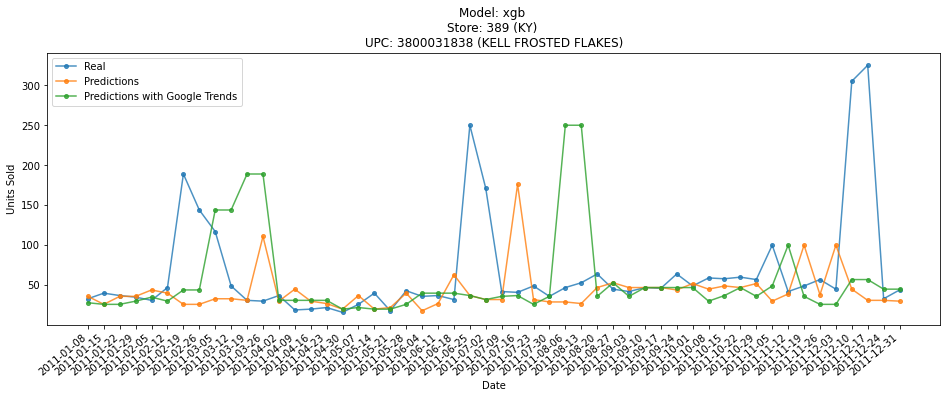

Std xgb: 26.46 and with Google Trends: 54.25


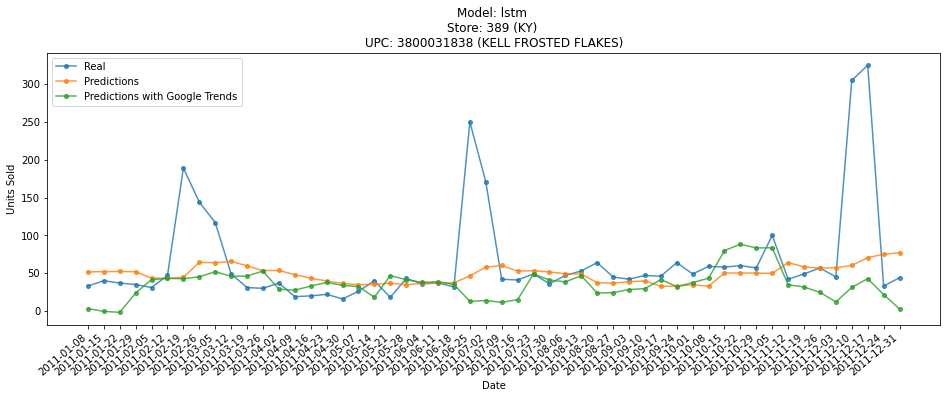

Std lstm: 11.46 and with Google Trends: 19.65






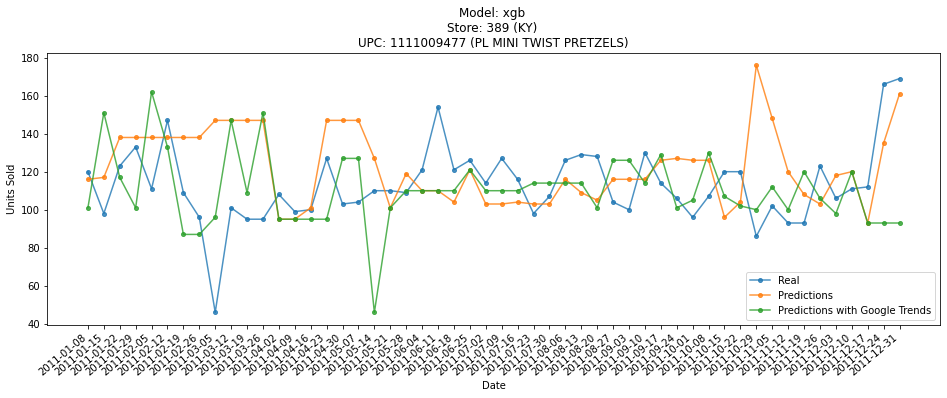

Std xgb: 19.35 and with Google Trends: 18.91


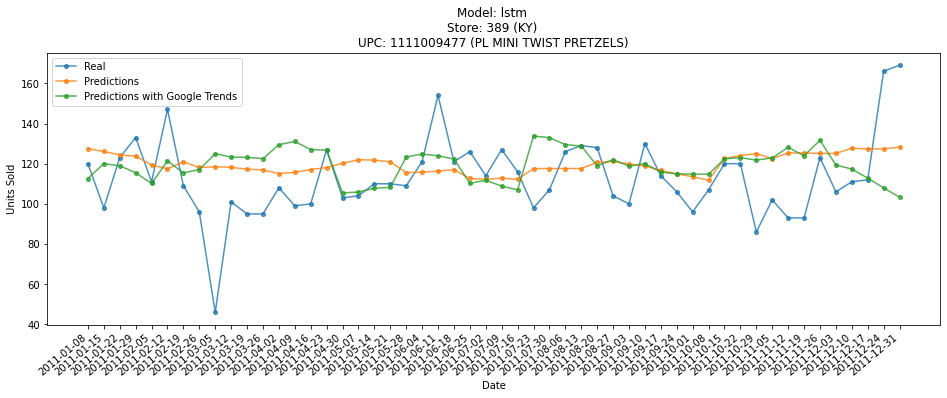

Std lstm: 4.60 and with Google Trends: 7.79






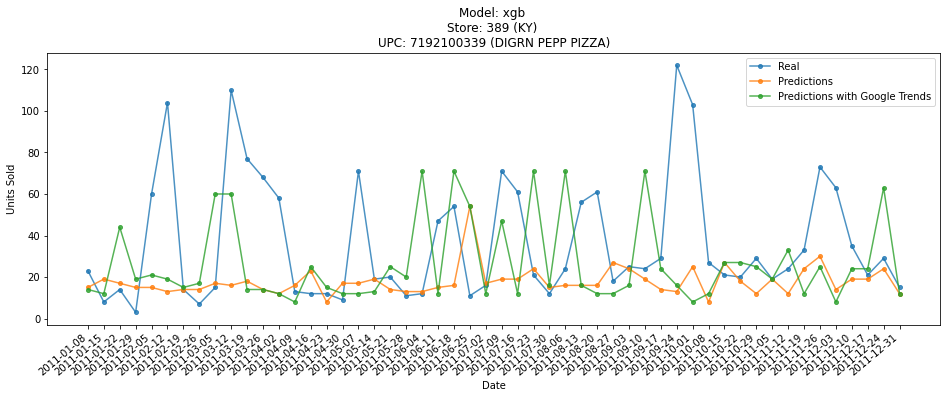

Std xgb: 6.92 and with Google Trends: 19.94


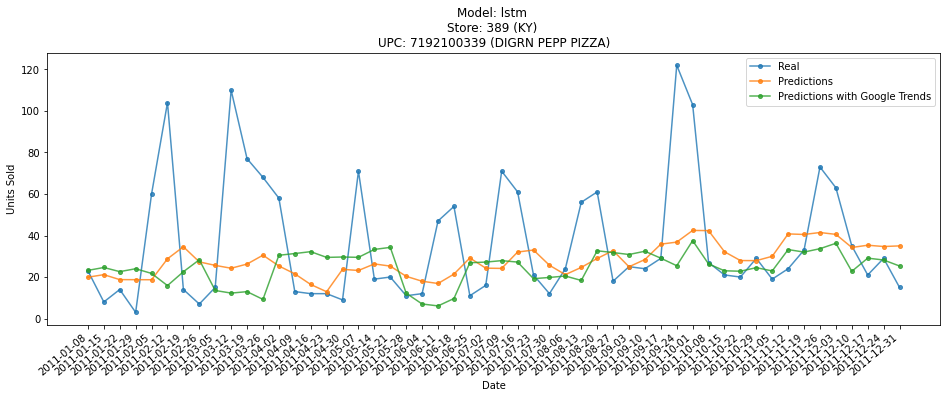

Std lstm: 7.43 and with Google Trends: 7.80






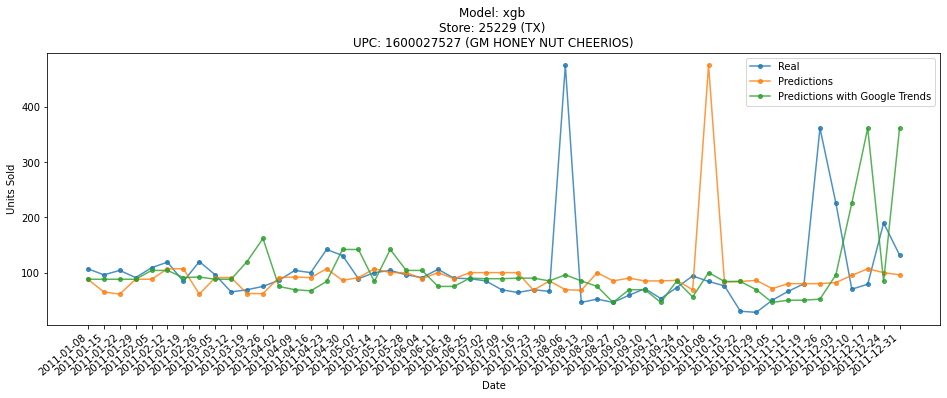

Std xgb: 55.48 and with Google Trends: 61.31


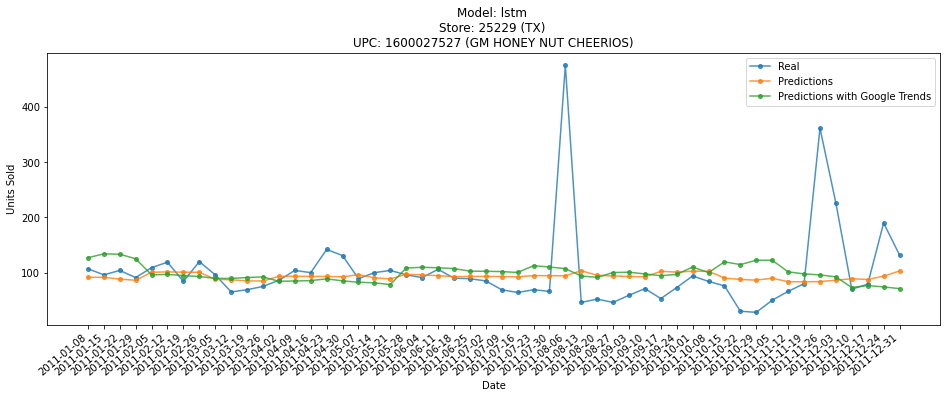

Std lstm: 5.56 and with Google Trends: 15.06






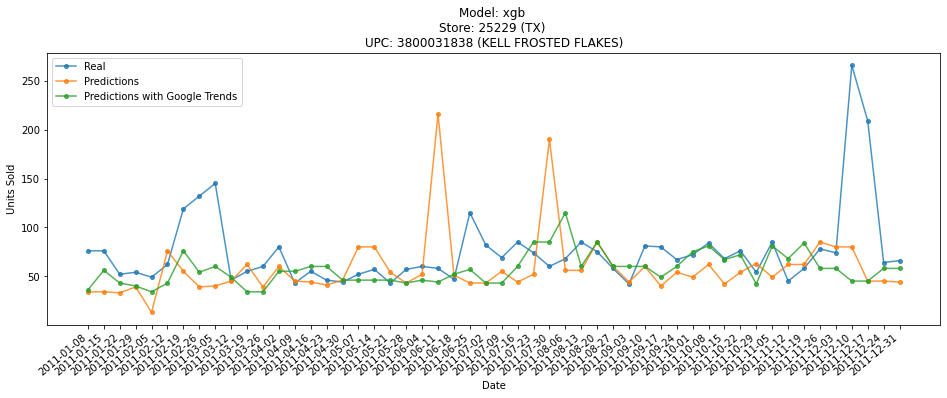

Std xgb: 32.82 and with Google Trends: 16.31


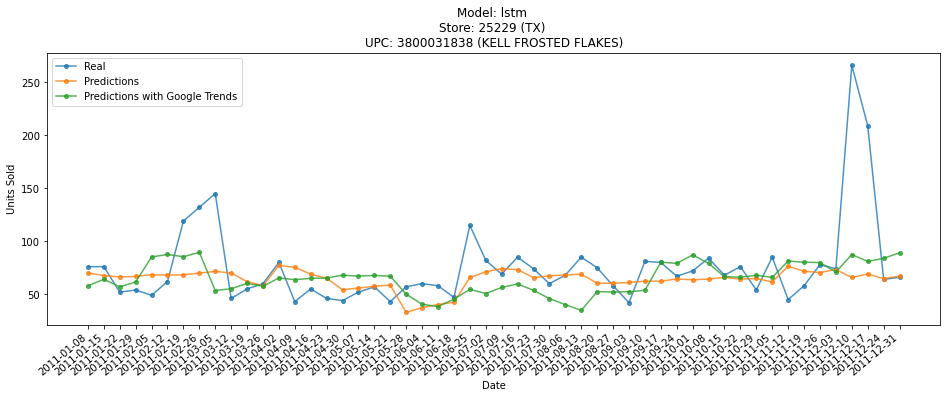

Std lstm: 9.15 and with Google Trends: 14.64






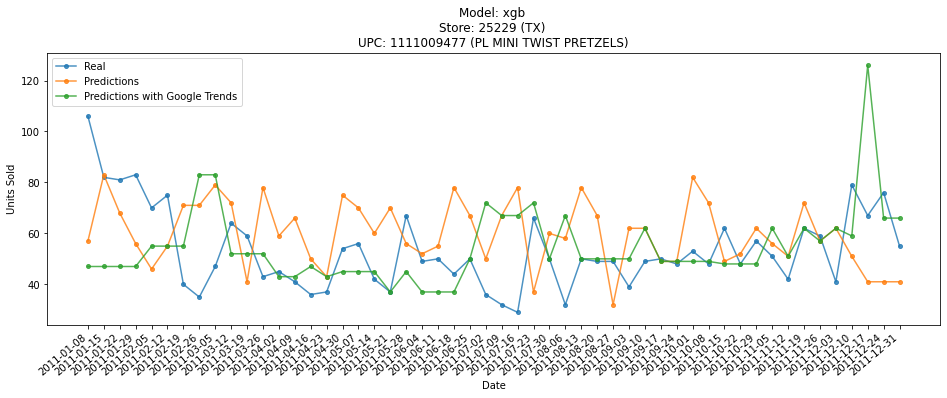

Std xgb: 12.72 and with Google Trends: 14.69


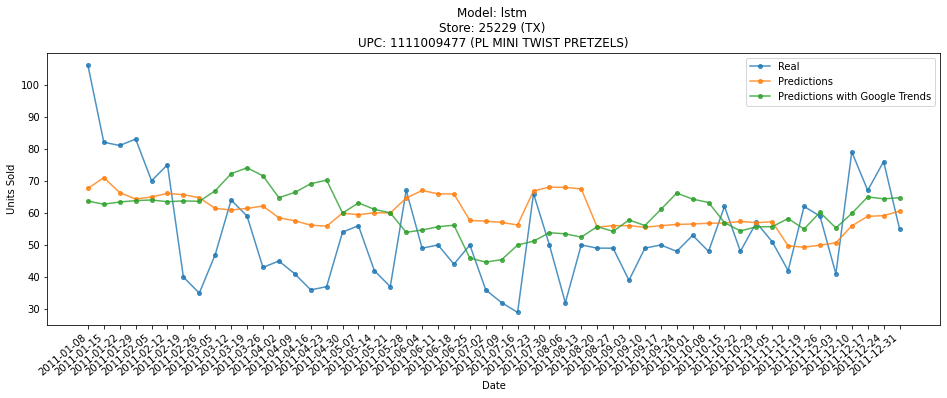

Std lstm: 5.22 and with Google Trends: 6.69






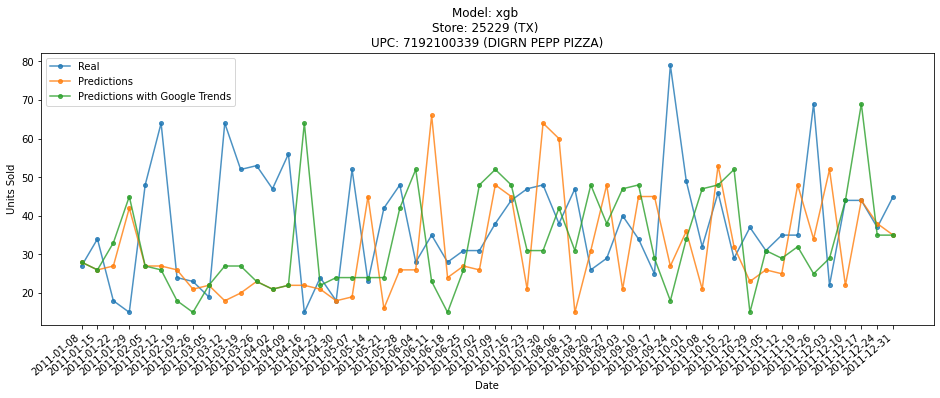

Std xgb: 12.96 and with Google Trends: 12.66


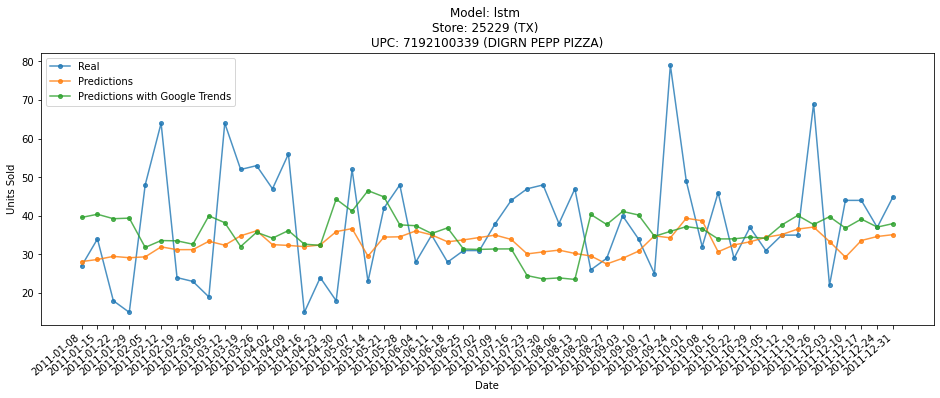

Std lstm: 2.78 and with Google Trends: 4.96






In [21]:
# Plot the forecast for each model

for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        
        fig, axs = plt.subplots(1,1, figsize=(16,5))
        
        plt.plot(temp['y_true'], marker='o', markersize=4, 
                 label='Real',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}'], marker='o', markersize=4, 
                 label='Predictions',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}_gtrend'], marker='o', markersize=4, 
                 label='Predictions with Google Trends',alpha=0.8)

        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        plt.title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        plt.xlabel('Date')
        plt.ylabel('Units Sold')
        plt.legend()
        for tick in axs.get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
        plt.show()
        if model == 'xgb':
            print(f"Std xgb: {temp['y_pred_xgb'].std():.2f} and with Google Trends: {temp['y_pred_xgb_gtrend'].std():.2f}")
        if model == 'lstm':
            print(f"Std lstm: {temp['y_pred_lstm'].std():.2f} and with Google Trends: {temp['y_pred_lstm_gtrend'].std():.2f}")
        
    print('\n\n\n')


In [22]:
# When we add google trends, there seem to be more variation in the predictions

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Statistical Test

- H0: XGBoost and XGBoost_GoogleTrends have the same distribution. Likewise, LSTM and LSTM_GoogleTrends have the same distribution.
- If there is no statistical difference in the average MASE/RMSSE obtained between the two experiments we reject the null hypothesis. At the α = 0.05 level, if we get a p-value less than 0.05 we reject the null hypothesis. ( since the p-value is inferior to α ).

Flach, P. A. (2017). Machine learning: the art and science of algorithms that make sense of data. Cambridge: Cambridge University Press.

In [23]:
from scipy import stats

In [24]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','rmse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmse')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

xgb xgb_gtrend  xgb - xgb_gtrend
(389, 1111009477)    30.1742    28.3342          1.839973
(389, 1600027527)    78.5149     81.871         -3.356087
(389, 3800031838)     77.003    85.7299         -8.726901
(389, 7192100339)    36.0187    38.2572         -2.238535
(2277, 1111009477)   66.1407    51.9602         14.180501
(2277, 1600027527)   102.982    113.625        -10.642467
(2277, 3800031838)   63.8657    59.0611          4.804611
(2277, 7192100339)   51.3191    52.0615         -0.742402
(25229, 1111009477)  22.6036    21.3339          1.269723
(25229, 1600027527)  94.0451    94.2705         -0.225379
(25229, 3800031838)  54.1794     46.089          8.090407
(25229, 7192100339)  20.7772    20.8017         -0.024513
std                  27.2367    30.0916          6.738160
average              58.1353    57.7829          0.352411
p_value                    -          -          0.859525

In [25]:
# LSTM

paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','rmse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmse')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend']
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lstm lstm_gtrend  lstm - lstm_gtrend
(389, 1111009477)    20.8424     23.8337           -2.991255
(389, 1600027527)     77.454     75.4711            1.982898
(389, 3800031838)    65.7201     74.7466           -9.026469
(389, 7192100339)    29.7248     33.3912           -3.666443
(2277, 1111009477)   51.7109     47.1599            4.550989
(2277, 1600027527)   97.9523     99.0187           -1.066348
(2277, 3800031838)   54.0854     55.2182           -1.132794
(2277, 7192100339)   36.8017     38.2474           -1.445635
(25229, 1111009477)  16.0899     16.6399           -0.549956
(25229, 1600027527)  74.0162     75.9035           -1.887240
(25229, 3800031838)   40.005     39.2624            0.742648
(25229, 7192100339)  14.5259     15.8795           -1.353610
std                  26.6344     26.7294            3.280129
average              48.2441     49.5643           -1.320268
p_value                    -           -            0.190744

### MASE T-Test (XGBoost)

In [26]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','mase','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='mase')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


xgb xgb_gtrend  xgb - xgb_gtrend
(389, 1111009477)     1.30353    1.23775          0.065780
(389, 1600027527)    0.788326   0.864964         -0.076638
(389, 3800031838)     1.08004    1.28482         -0.204782
(389, 7192100339)     1.21531    1.44492         -0.229603
(2277, 1111009477)    1.73389    1.39787          0.336020
(2277, 1600027527)    1.13067     1.0765          0.054172
(2277, 3800031838)    1.03483   0.917909          0.116925
(2277, 7192100339)    1.39516    1.40602         -0.010854
(25229, 1111009477)   1.36954    1.06078          0.308764
(25229, 1600027527)   1.18336    1.33276         -0.149406
(25229, 3800031838)   1.12654   0.869139          0.257404
(25229, 7192100339)   1.21585    1.18848          0.027371
std                  0.230037    0.21223          0.190387
average               1.21476    1.17349          0.041263
p_value                     -          -          0.468544

### MASE T-Test (LSTM)

In [27]:
paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','mase','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='mase')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend'] # [100] * 12#
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
#                            'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], [100] * 12)[1]]})
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lstm lstm_gtrend  lstm - lstm_gtrend
(389, 1111009477)    0.930933    0.970629           -0.039696
(389, 1600027527)    0.938255    0.894177            0.044078
(389, 3800031838)    0.922607     1.05609           -0.133487
(389, 7192100339)     1.09859     1.17302           -0.074432
(2277, 1111009477)    1.37581     1.25539            0.120425
(2277, 1600027527)   0.861527     0.92456           -0.063033
(2277, 3800031838)   0.764085    0.854535           -0.090450
(2277, 7192100339)   0.995342     1.08312           -0.087781
(25229, 1111009477)  0.959991    0.994894           -0.034904
(25229, 1600027527)  0.979011     1.18667           -0.207657
(25229, 3800031838)  0.711687    0.816799           -0.105112
(25229, 7192100339)  0.852097    0.962253           -0.110157
std                    0.1696    0.138668            0.084086
average              0.949161     1.01435           -0.065184
p_value                     -           -            0.021203

### RMSSE T-Test (XGBoost)

In [28]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','rmsse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmsse')
)

paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


xgb xgb_gtrend  xgb - xgb_gtrend
(389, 1111009477)     1.29259    1.21377          0.078820
(389, 1600027527)    0.658713   0.686869         -0.028156
(389, 3800031838)     1.06907    1.19023         -0.121160
(389, 7192100339)     1.15496    1.22674         -0.071780
(2277, 1111009477)    1.65862    1.30302          0.355607
(2277, 1600027527)   0.853968    0.94222         -0.088251
(2277, 3800031838)   0.851788   0.787708          0.064080
(2277, 7192100339)    1.23751    1.25541         -0.017902
(25229, 1111009477)   1.20973    1.14177          0.067955
(25229, 1600027527)   1.09018    1.09279         -0.002613
(25229, 3800031838)  0.878874   0.747635          0.131239
(25229, 7192100339)   1.04115    1.04238         -0.001228
std                  0.261113   0.212746          0.126548
average                1.0831    1.05255          0.030551
p_value                     -          -          0.420786

### RMSSE T-Test (LSTM)

In [29]:
paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','rmsse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmsse')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend'] # [100] * 12#
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
#                            'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], [100] * 12)[1]]})
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

C:\Users\feras\Anaconda3\envs\ForecastingRetailSales\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lstm lstm_gtrend  lstm - lstm_gtrend
(389, 1111009477)    0.892842     1.02098           -0.128139
(389, 1600027527)    0.649812    0.633176            0.016636
(389, 3800031838)    0.912423     1.03774           -0.125319
(389, 7192100339)    0.953144     1.07071           -0.117567
(2277, 1111009477)    1.29676     1.18264            0.114126
(2277, 1600027527)   0.812259    0.821101           -0.008843
(2277, 3800031838)   0.721347    0.736455           -0.015108
(2277, 7192100339)   0.887436    0.922296           -0.034860
(25229, 1111009477)  0.861122    0.890555           -0.029433
(25229, 1600027527)  0.858002    0.879879           -0.021877
(25229, 3800031838)  0.648944    0.636897            0.012047
(25229, 7192100339)  0.727897    0.795727           -0.067830
std                  0.173442    0.172001            0.069487
average              0.851833     0.88568           -0.033847
p_value                     -           -            0.119649